In [1]:
import numpy as np
import gym
import random

In [3]:
env = gym.make('Taxi-v3').env

In [5]:
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [6]:
action_space = env.action_space
observation_space = env.observation_space

In [10]:
# action space assignment
'''
0 = south
1 = north
2 = east
3 = west
4 = pickup
5 = dropoff
'''

'\n0 = south\n1 = north\n2 = east\n3 = west\n4 = pickup\n5 = dropoff\n'

In [11]:
state = env.encode(3,1,2,0)
print(state)

env.s = state
env.render()

328
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [12]:
env.P[state]

{0: [(1.0, 428, -1, False)],
 1: [(1.0, 228, -1, False)],
 2: [(1.0, 348, -1, False)],
 3: [(1.0, 328, -1, False)],
 4: [(1.0, 328, -10, False)],
 5: [(1.0, 328, -10, False)]}

In [19]:
epochs = 0
penalties, reward = 0, 0

frames = []

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    
    if reward == -10:
        penalties += 1
    
    # for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
    })
    
    epochs += 1

print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 589
Penalties incurred: 201


In [20]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)
        
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 589
State: 0
Action: 5
Reward: 20


In [22]:
# q learning: keep updating the the q values Q(S, A)
# update function: Q(S,A) = (1-alpha)Q(S,A) + alpha * (reward + gamma * maxQ(S', A))
q_table = np.zeros((observation_space.n, action_space.n))

In [24]:
# set up hyper params
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# for plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    state = env.reset()
    
    epochs, penalties, reward = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(q_table[state])
        
        next_state, reward, done, info = env.step(action)
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1-alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value
        
        if reward == -10:
            penalties += 1
        
        state = next_state
        epochs += 1
    
    if i%100 == 0:
        clear_output(wait=True)
        print(f'Episode: {i}')

Episode: 100000


In [25]:
q_table

array([[  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -2.41837066,  -2.3639511 ,  -2.41837066,  -2.3639511 ,
         -2.27325184, -11.363951  ],
       [ -1.870144  ,  -1.45024   ,  -1.870144  ,  -1.45024   ,
         -0.7504    , -10.45023986],
       ...,
       [ -1.07260943,   0.41599998,  -1.15108419,  -1.29188007,
         -2.73984583,  -3.44487026],
       [ -2.14680613,  -2.12208463,  -2.15882703,  -2.12208455,
         -5.15328559,  -5.72698562],
       [  2.82779117,   1.13744378,   3.9515849 ,  11.        ,
         -2.47161238,  -2.81711109]])

In [27]:
frames = []

In [28]:
total_epochs, total_penalties = 0, 0
episodes = 100

for _ in range(episodes):
    state = env.reset()
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info = env.step(action)

        if reward == -10:
            penalties += 1
            
        # for animation
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
        })


        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

In [29]:
print_frames(frames)

+---------+
|R: | : :G|
| : | : : |
| : : :_: |
| | : | : |
|Y| : |B: |
+---------+
  (South)

Timestep: 269
State: 276
Action: 0
Reward: -1


KeyboardInterrupt: 

In [26]:
import gym
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from IPython import display

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


class Agent:
    def __init__(self, params):
        for key, val in params.items():
            setattr(self, key, val)
        self.net = NeuralNet(self.state_space, 128, self.action_space)
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.replay = []
        self.steps = 0

    def train(self):
        if (len(self.replay)) < self.batch_size:
            return
        
        samples = random.sample(self.replay, self.batch_size)
        state, action, reward, next_state = zip(*samples)

        state = torch.tensor(state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.float)
        reward = torch.tensor(reward, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)

        y = reward + self.gamma * torch.max(self.net(state).detach(), dim=1)[0].view(self.batch_size, -1)
        pred = self.net(state).gather(1, action)

        loss = self.loss_fn(pred, y)
        self.optimizer.zero_grad()
        loss.backward()
        self.toptimizer.step()

    def epsilon_decay(self):
        return self.epsilon_low + (self.epsilon_high - self.epsilon_low) * (math.exp(-self.steps/self.decay))
    
    def act(self, cur_state):
        self.steps += 1
        epsilon = self.epsilon_decay()
        if random.uniform(0,1) < epsilon:
            action = random.randrange(self.action_space)
        else:
            state = torch.tensor(cur_state, dtype=torch.float).view(1,-1)
            action = torch.argmax(self.net(state)).item()
        return action
    
    def add_to_replay(self, state, action, reward, next_state):
        self.replay.append((state,action,reward,next_state))
        while len(self.replay) == self.capacity:
            self.replay.pop(0)
    

class DQN:
    def __init__(self):
        self.env = gym.make('CartPole-v0')
        params = {
            'gamma': 0.8,
            'epsilon_high': 0.9,
            'epsilon_low': 0.05,
            'decay': 200, 
            'lr': 0.001,
            'capacity': 10000,
            'batch_size': 64,
            'state_space': self.env.observation_space.shape[0],
            'action_space': self.env.action_space.n   
        }
        self.agent = Agent(params)
        self.score = []
        self.mean = []

    def train(self, episodes=1000):
        env = self.env
        state = env.reset()
        total_reward = 1

        for i in range(episodes):
            done = False
            while not done:
                action = self.agent.act(state)
                next_state, reward, done, info = env.step(action)

                if done:
                    reward = -1

                self.agent.add_to_replay(state, action, reward, next_state)
                total_reward += reward
                state = next_state
                self.agent.train()

                self.score.append(total_reward)
                self.mean.append( sum(self.score[-100:])/100)
                self.plot_result()
    
    def plot_result(self):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(20,10))
        plt.clf()

        score = self.score
        mean = self.mean

        plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(score)
        plt.plot(mean)
        plt.text(len(score)-1, score[-1], str(score[-1]))
        plt.text(len(mean)-1, mean[-1], str(mean[-1]))


In [27]:
dqn = DQN()

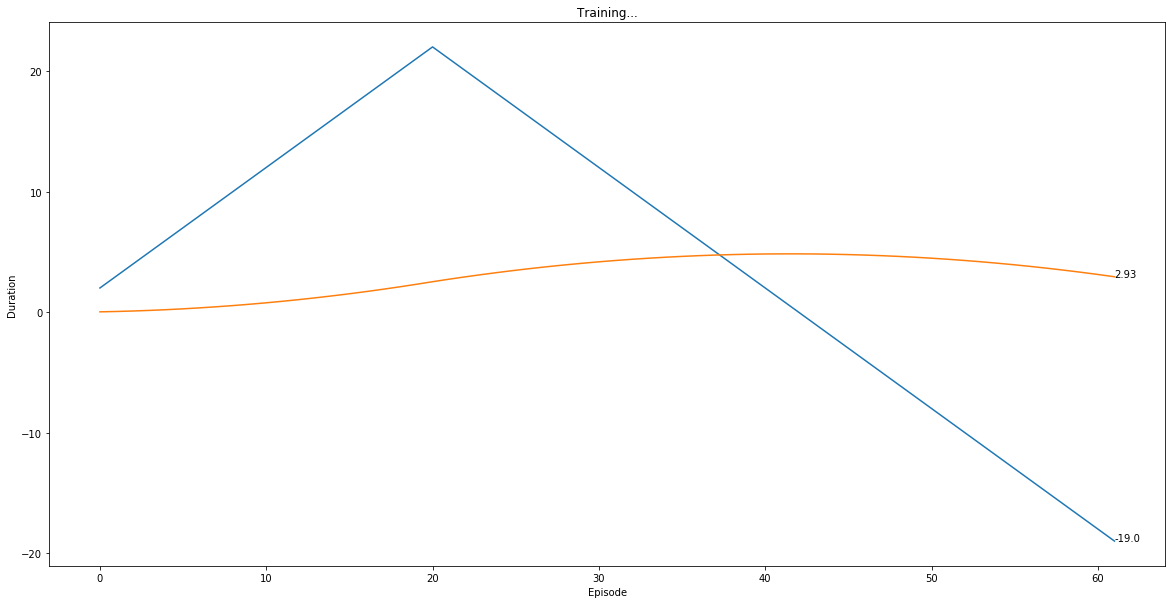

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

<Figure size 432x288 with 0 Axes>

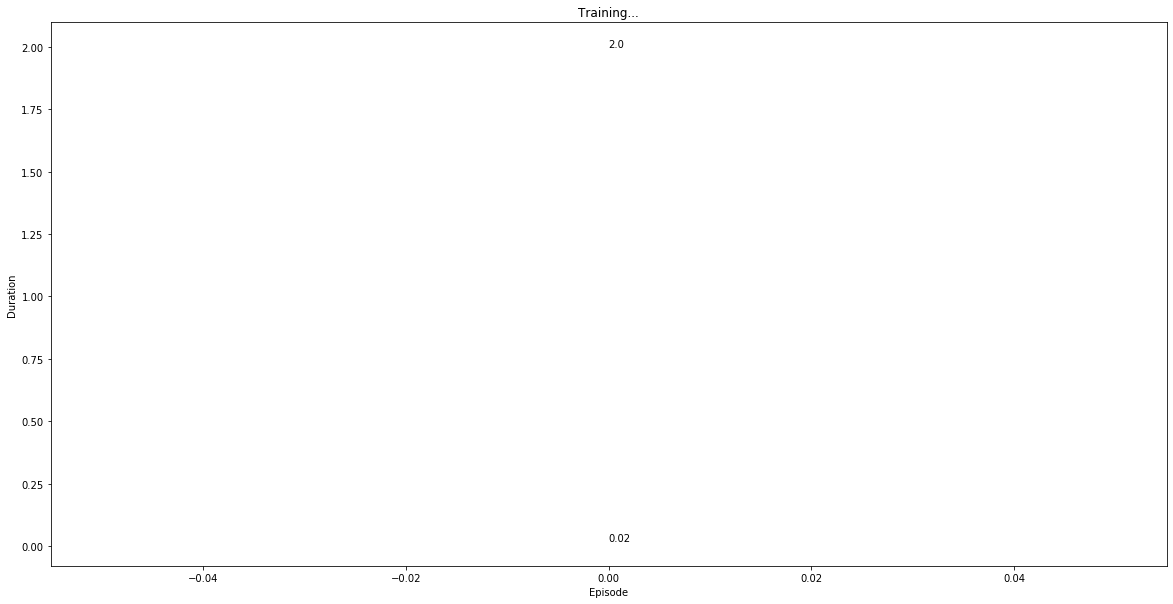

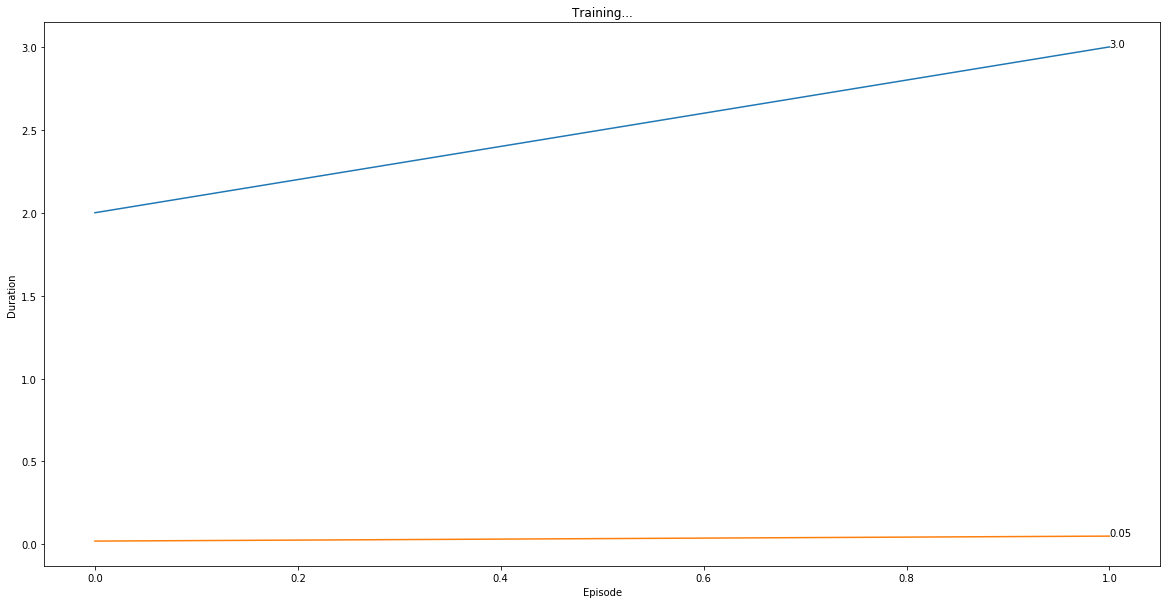

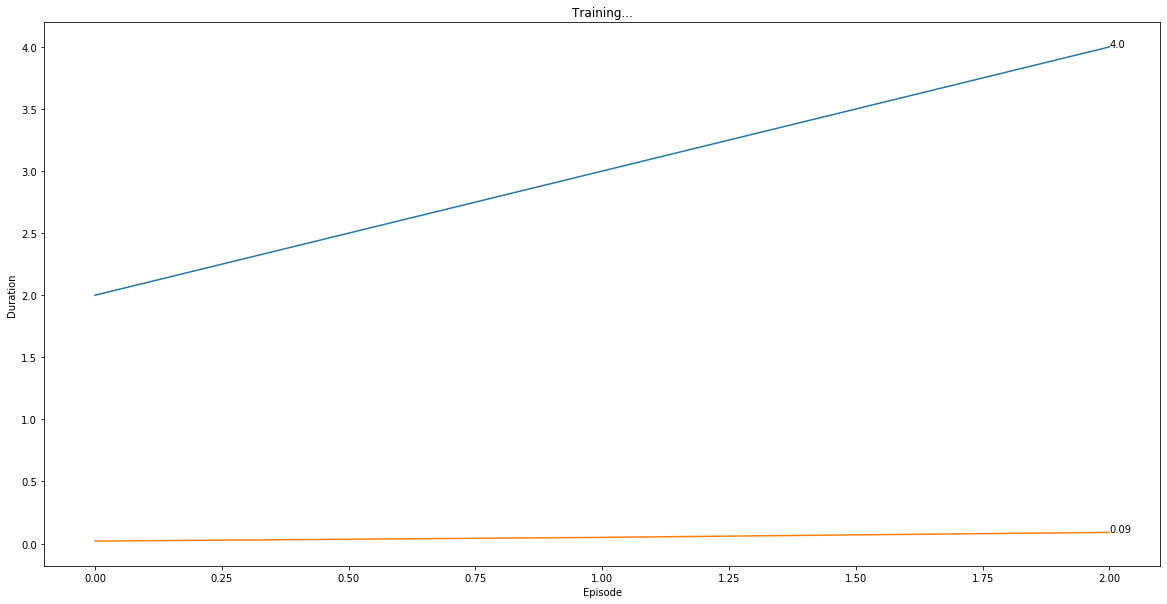

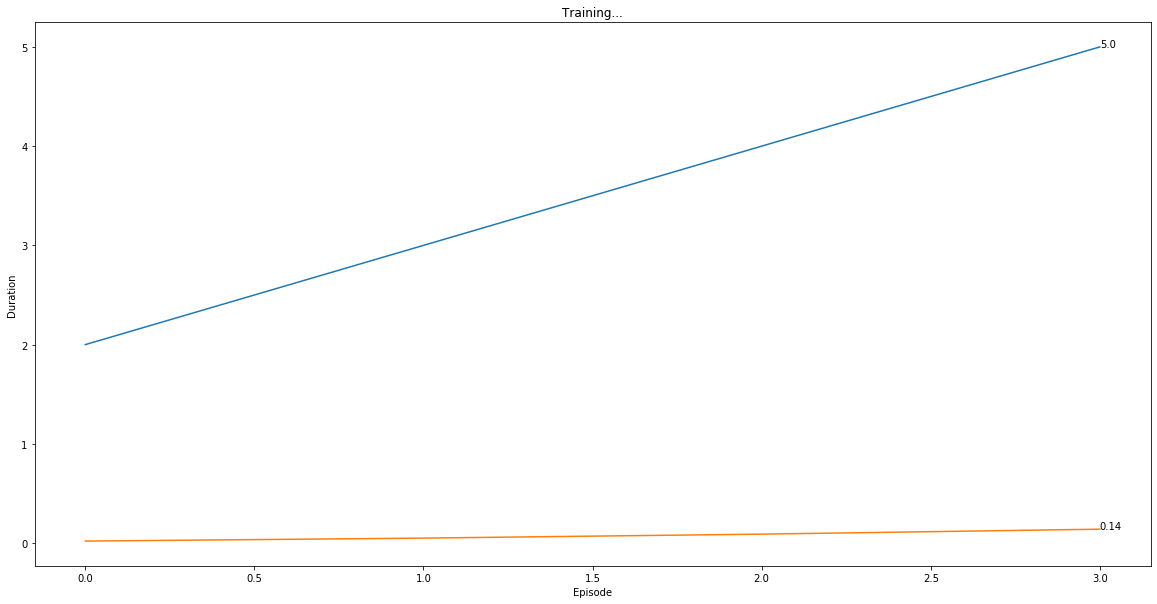

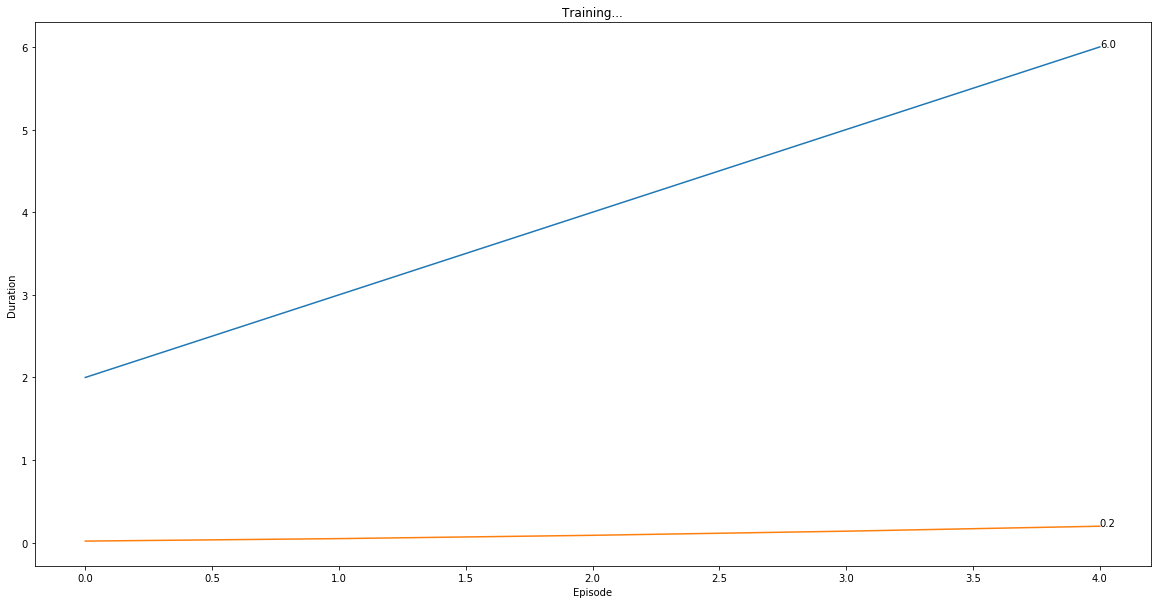

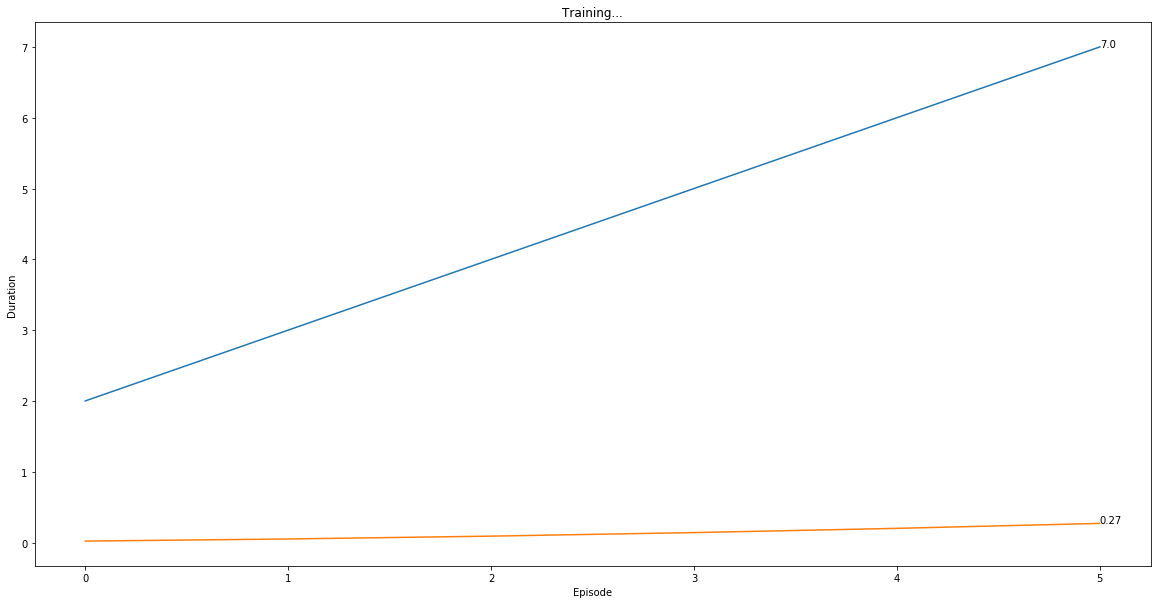

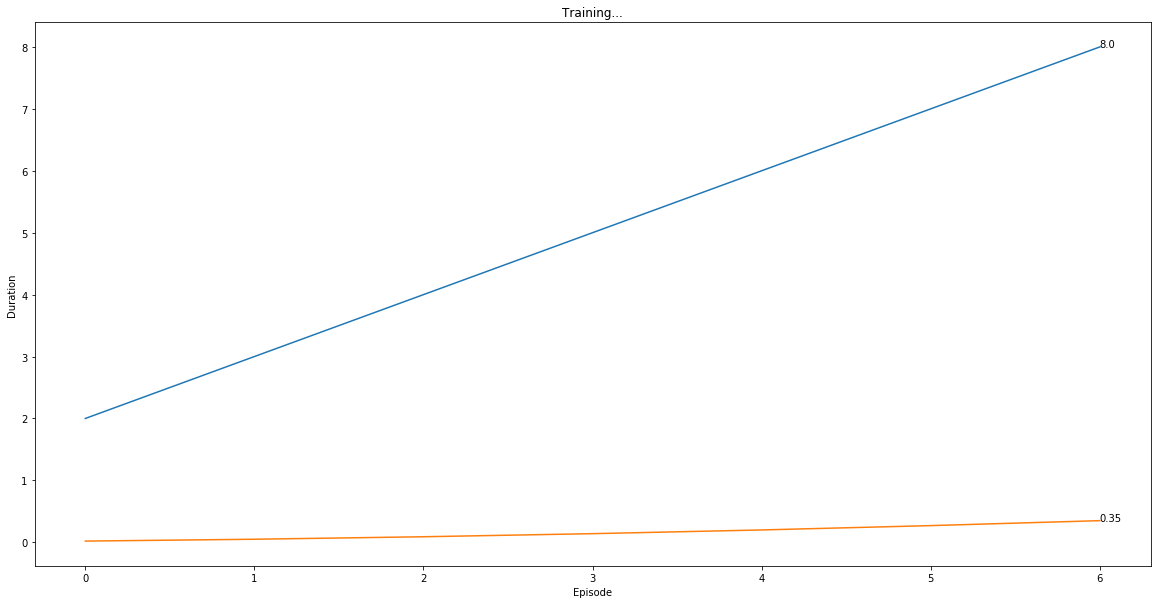

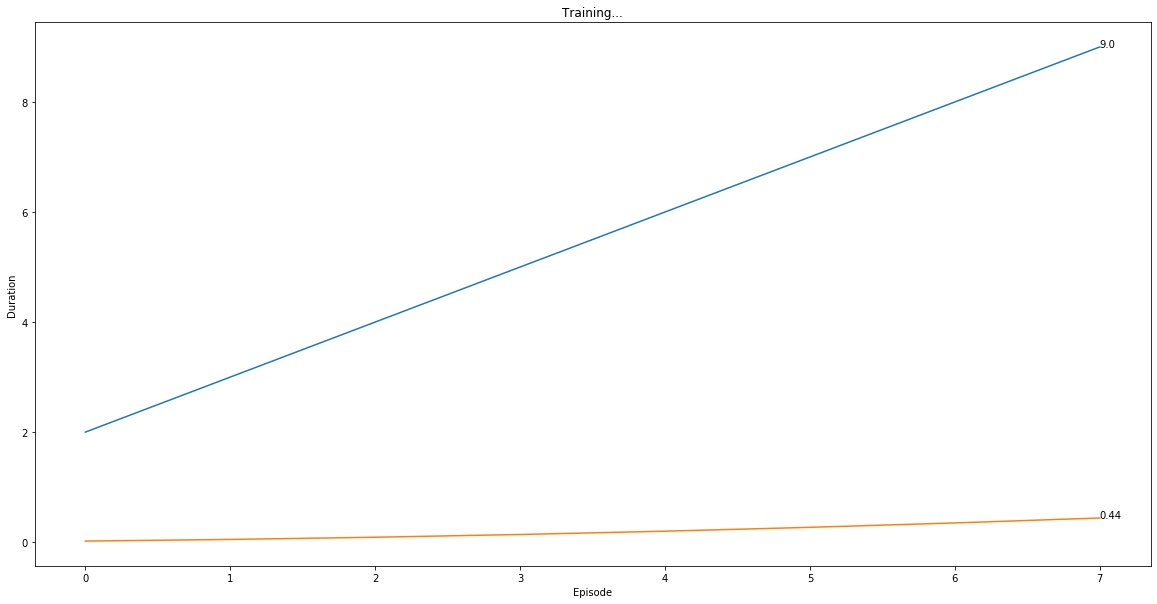

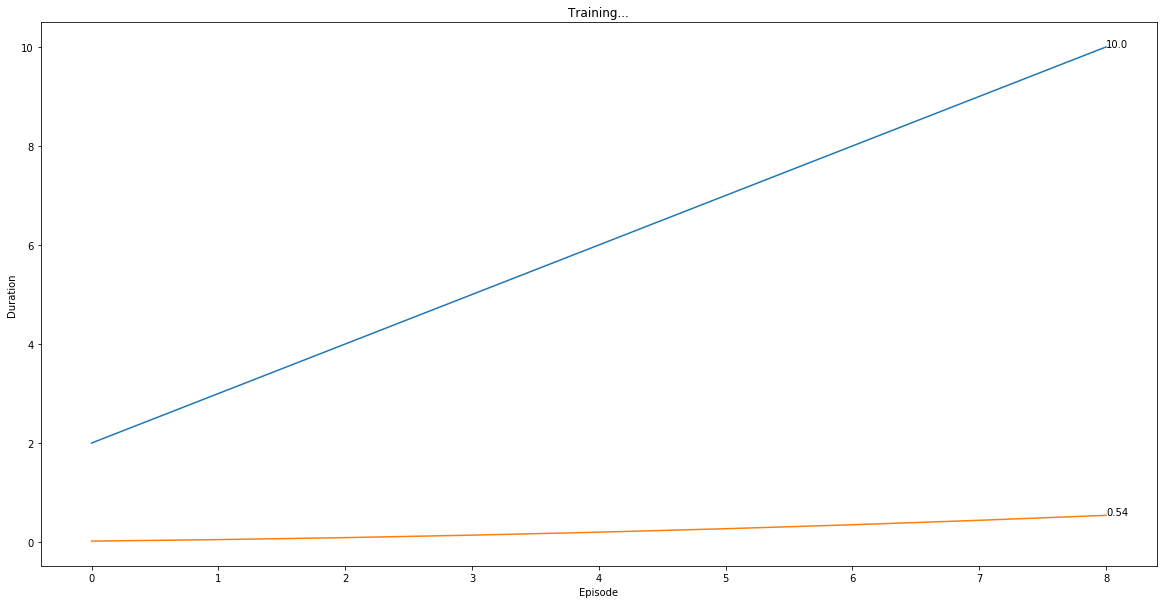

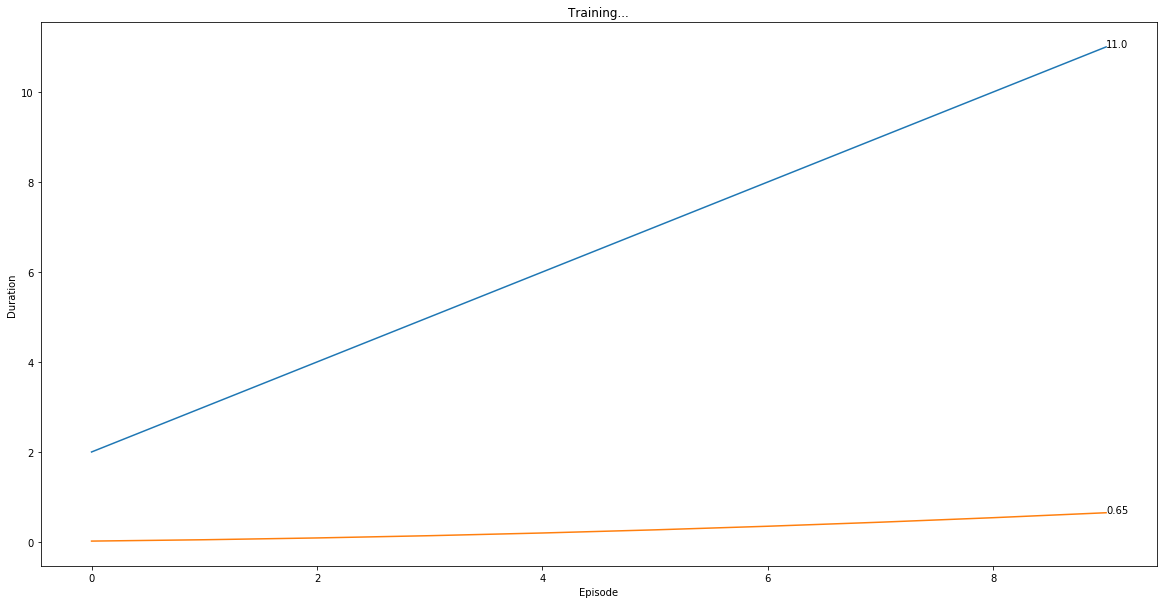

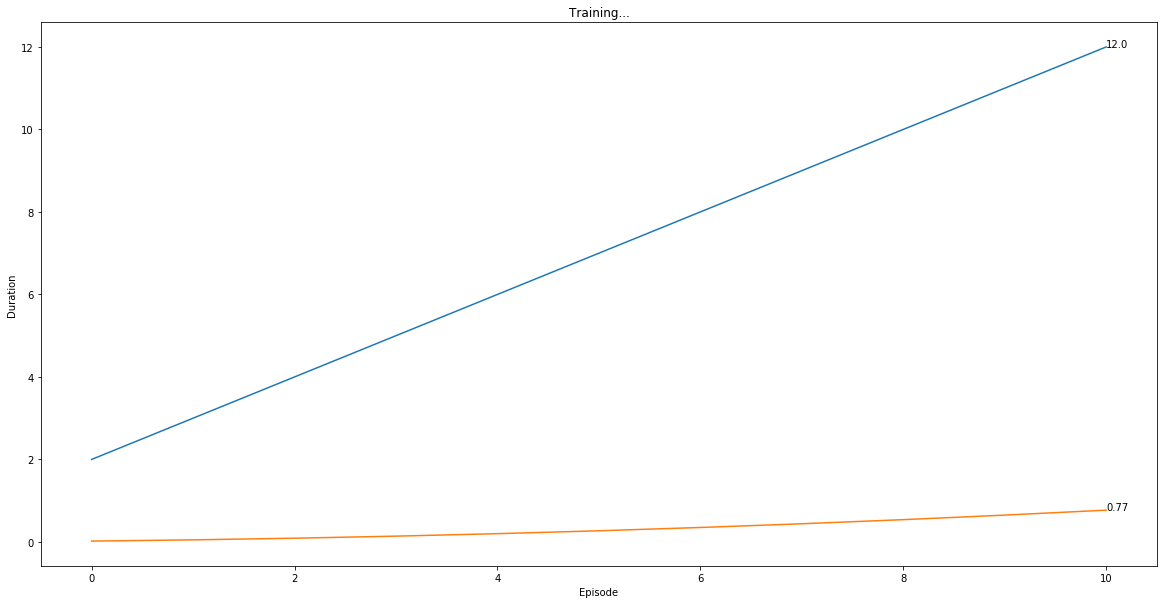

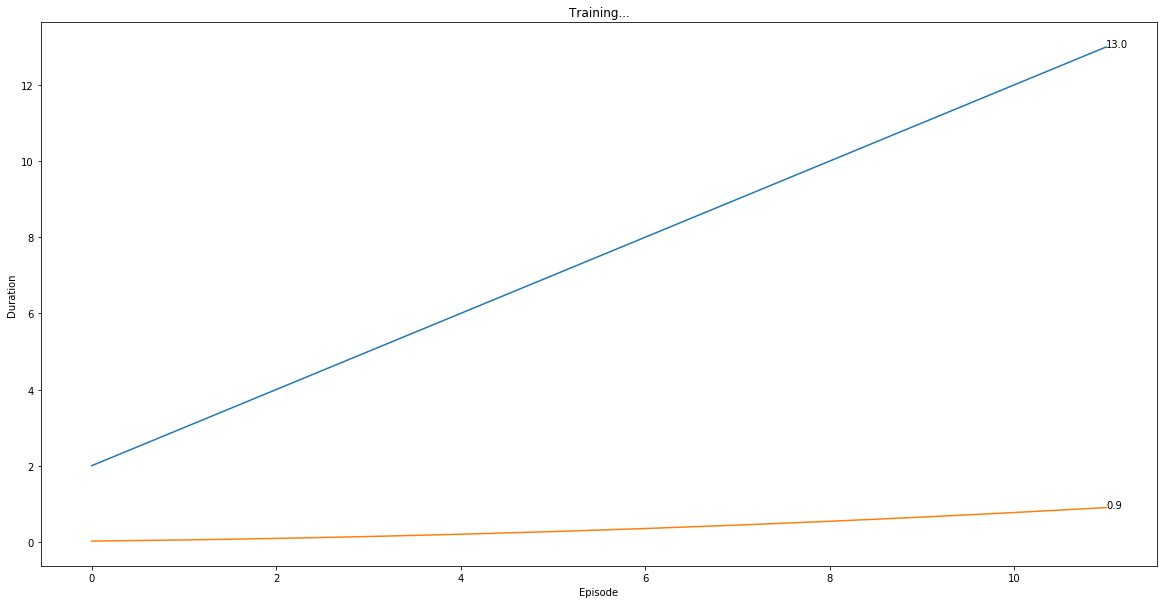

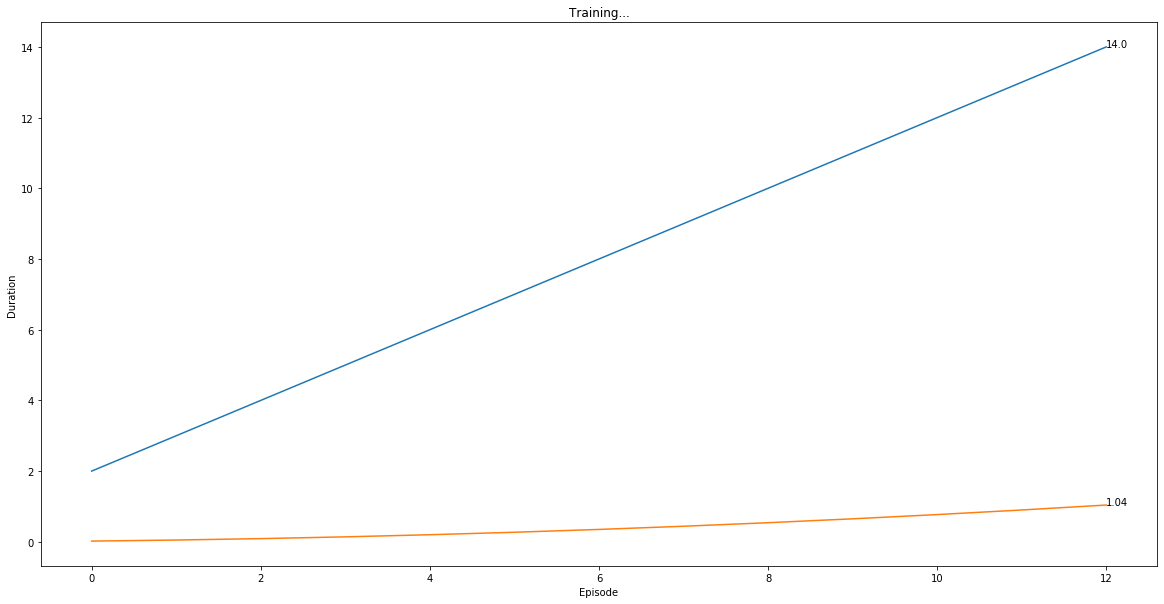

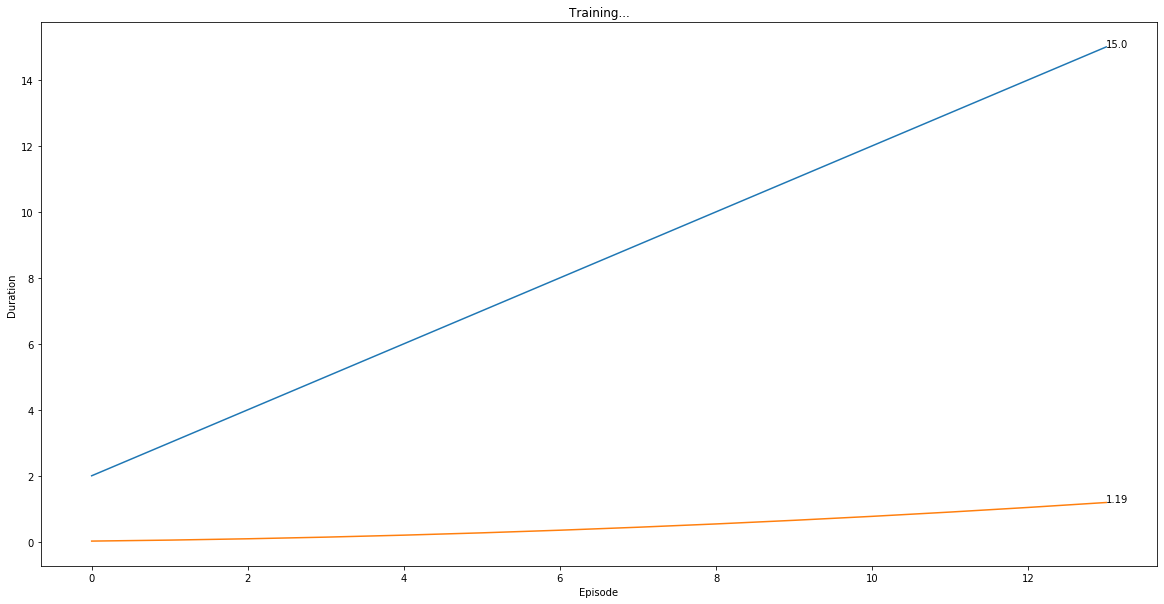

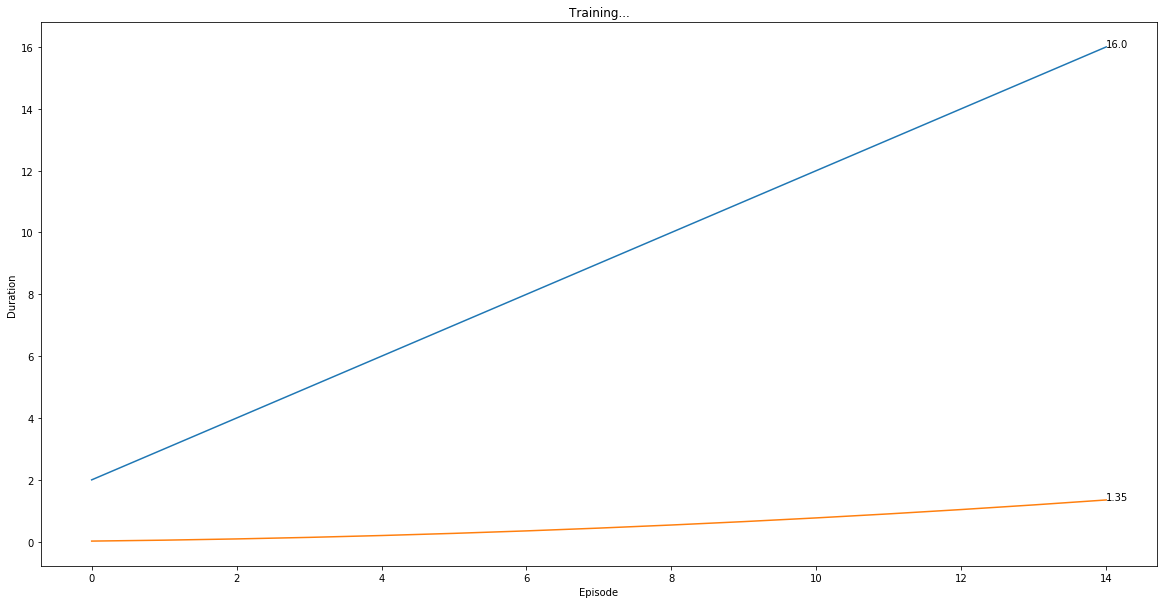

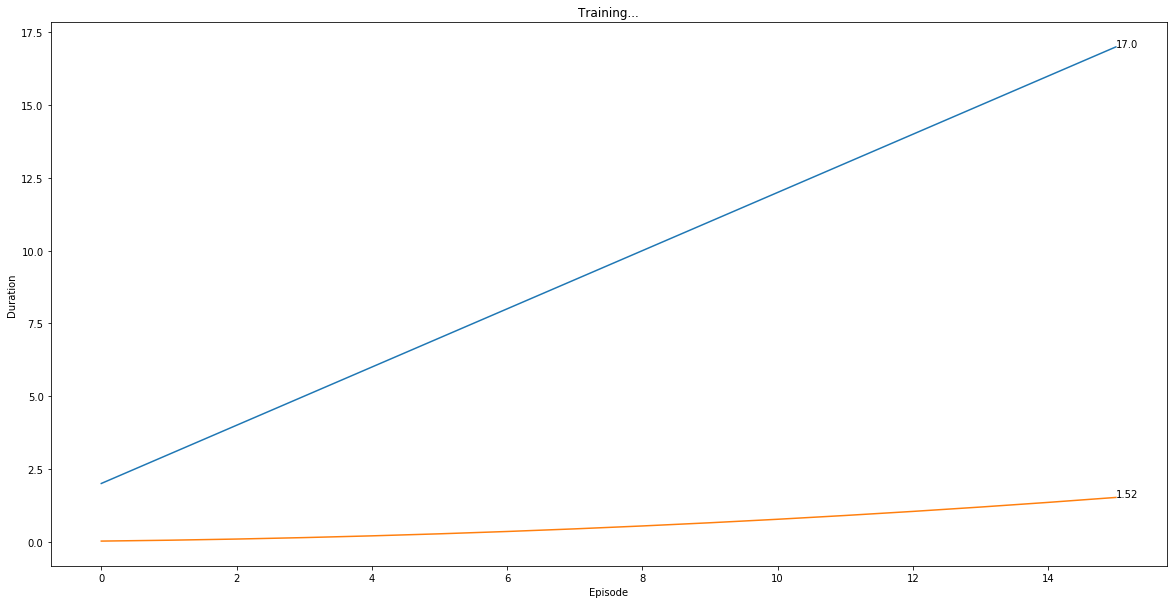

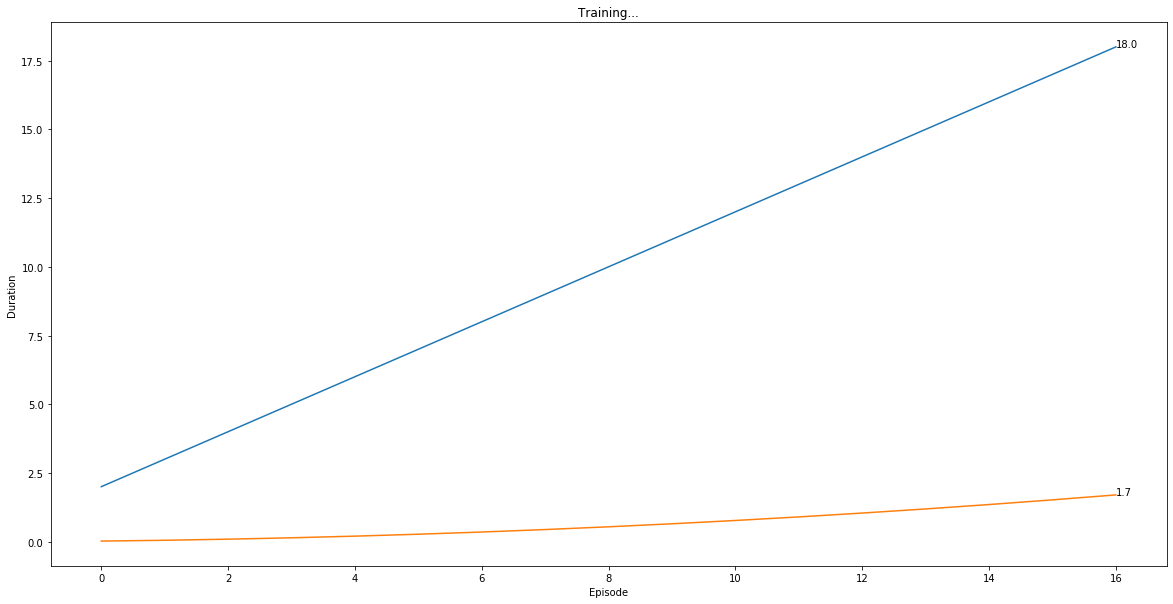

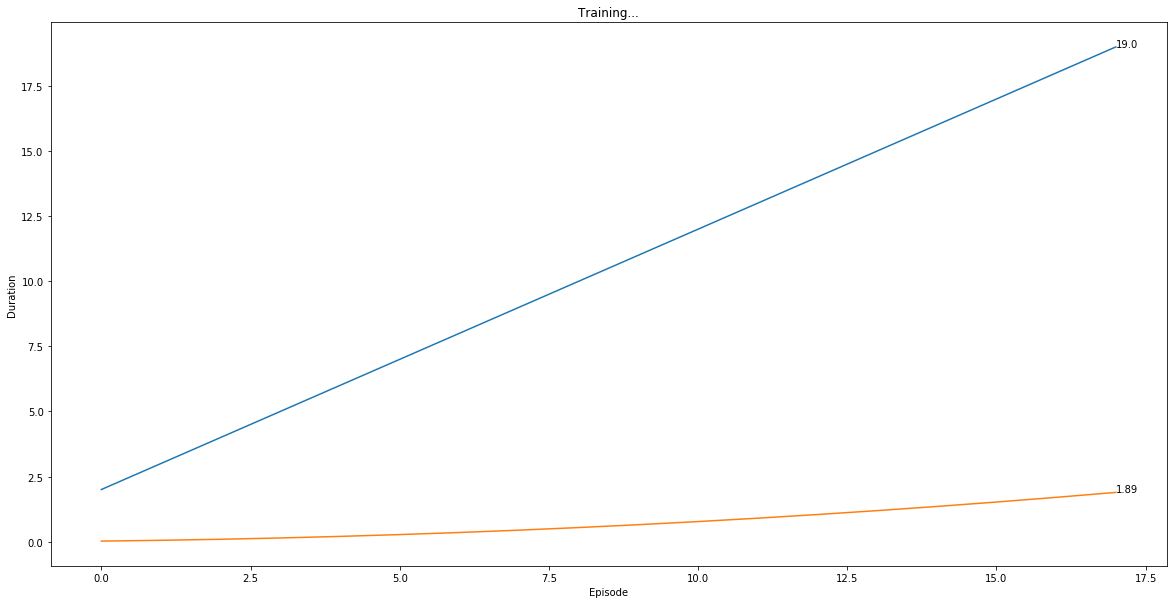

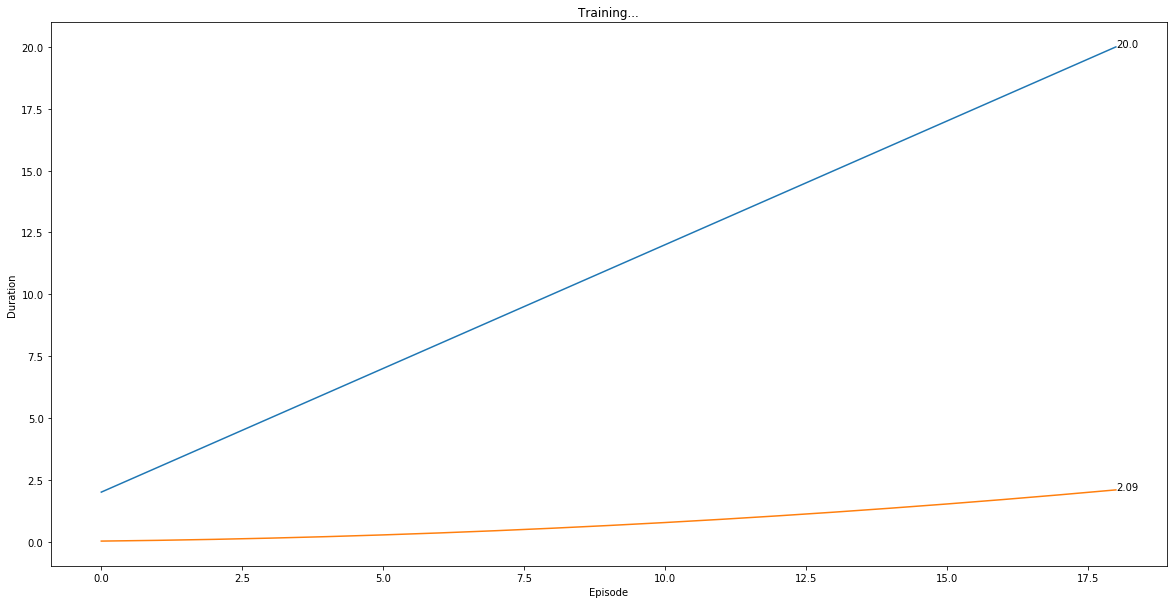

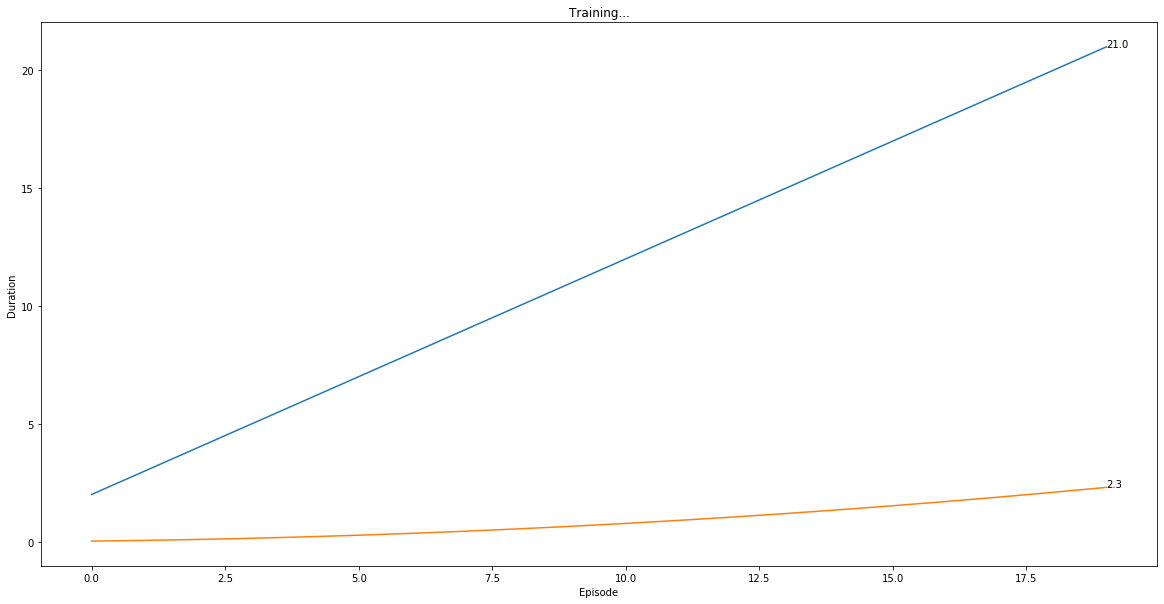

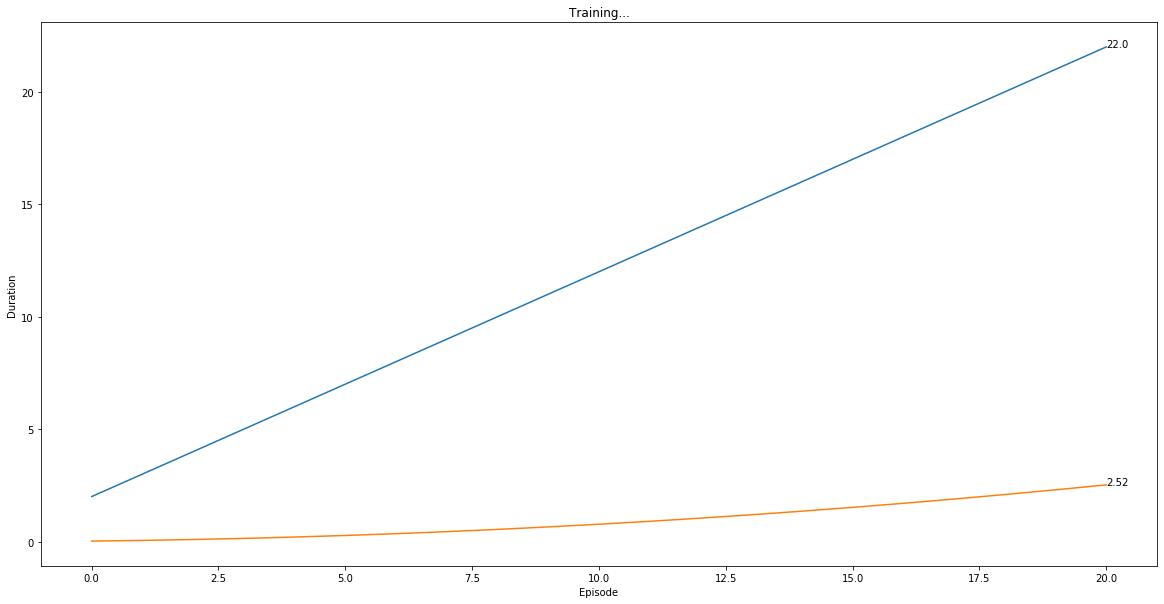

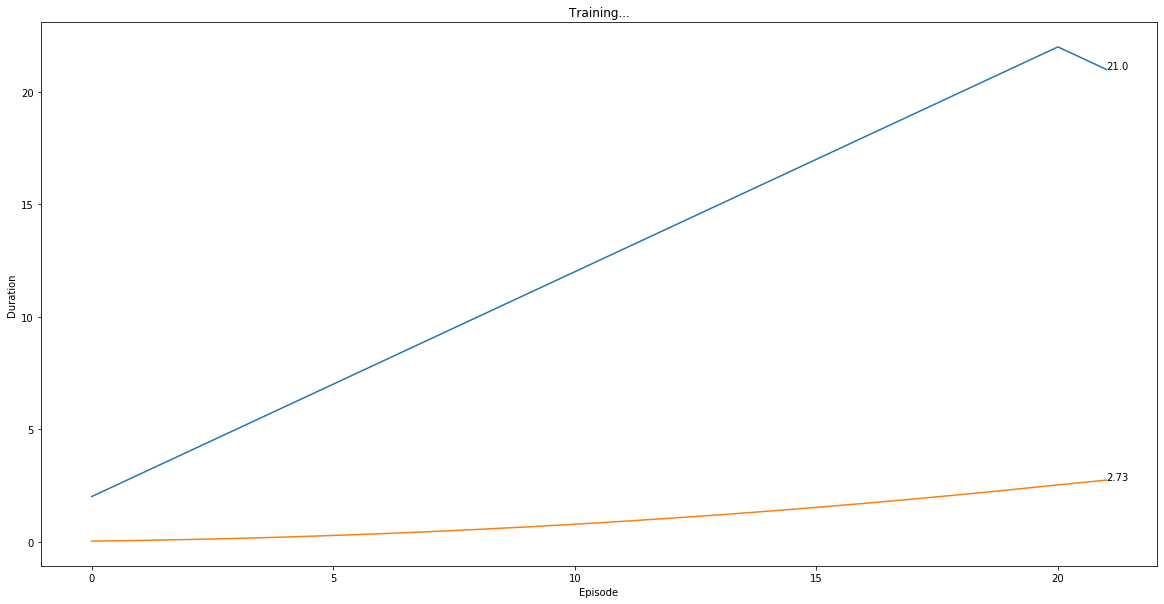

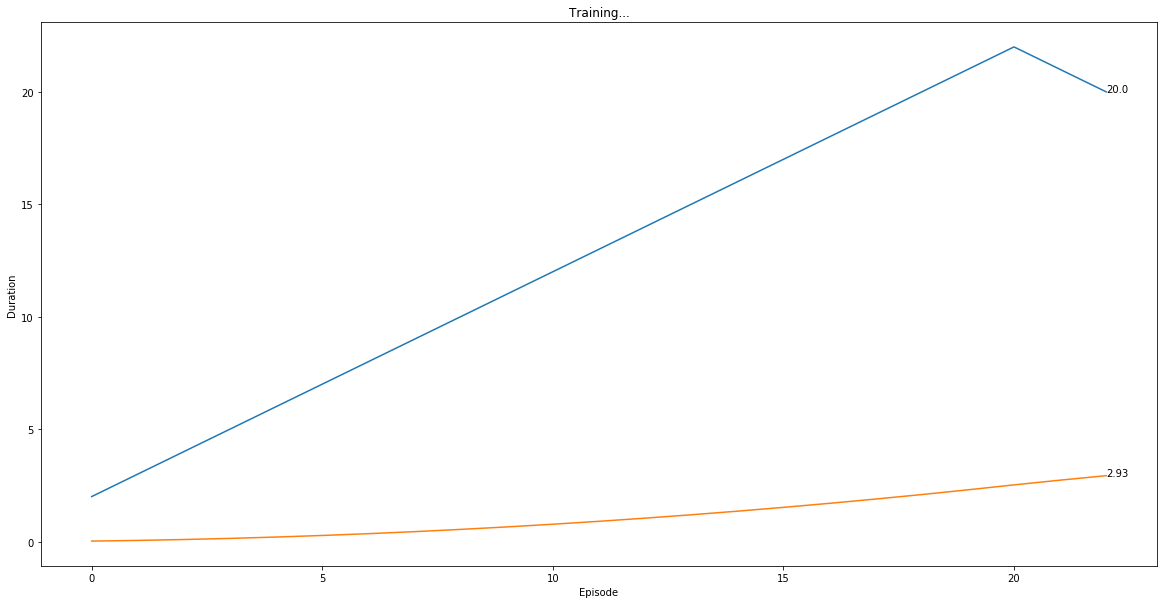

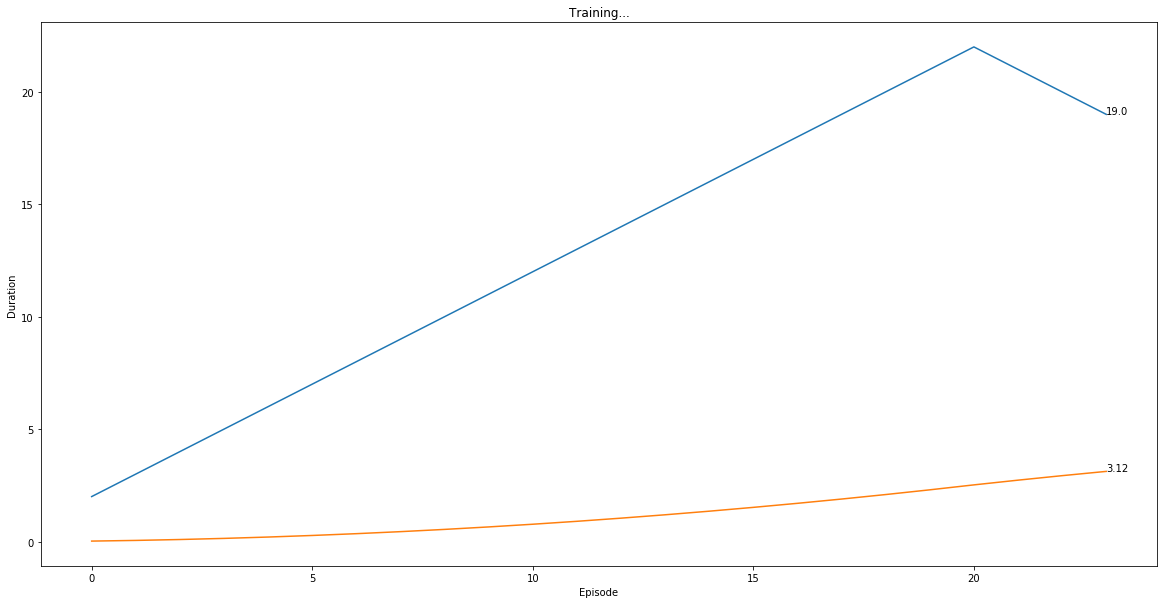

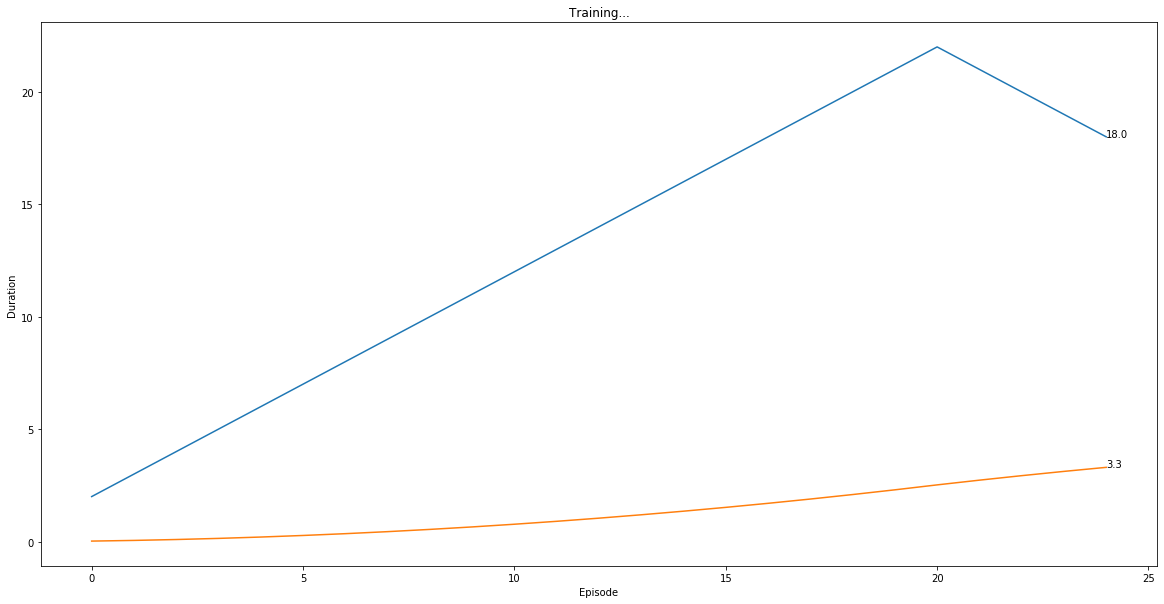

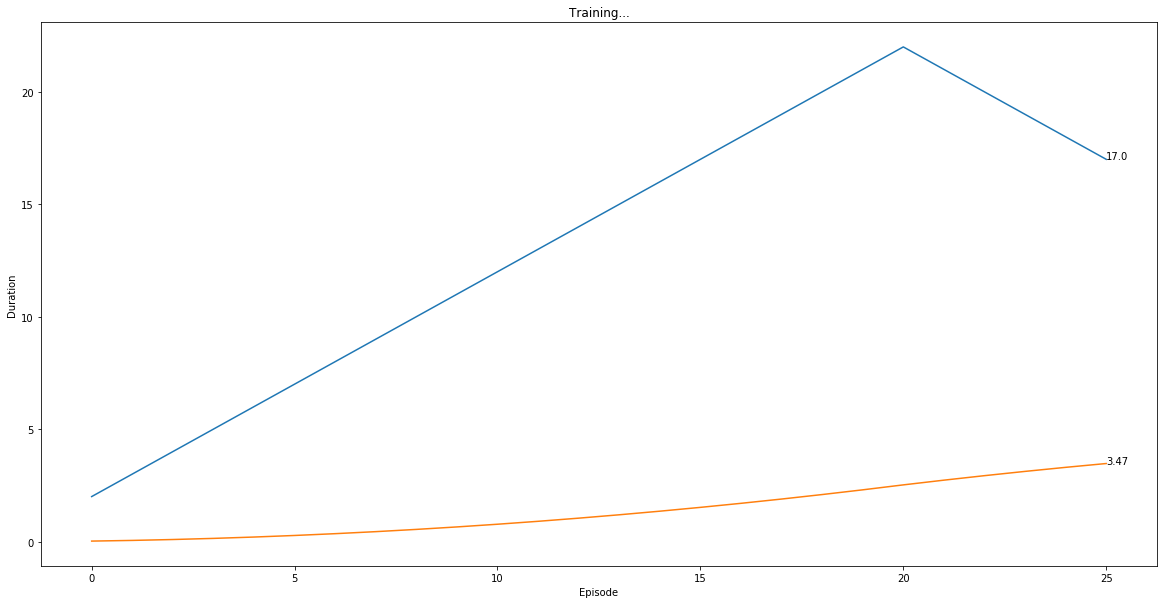

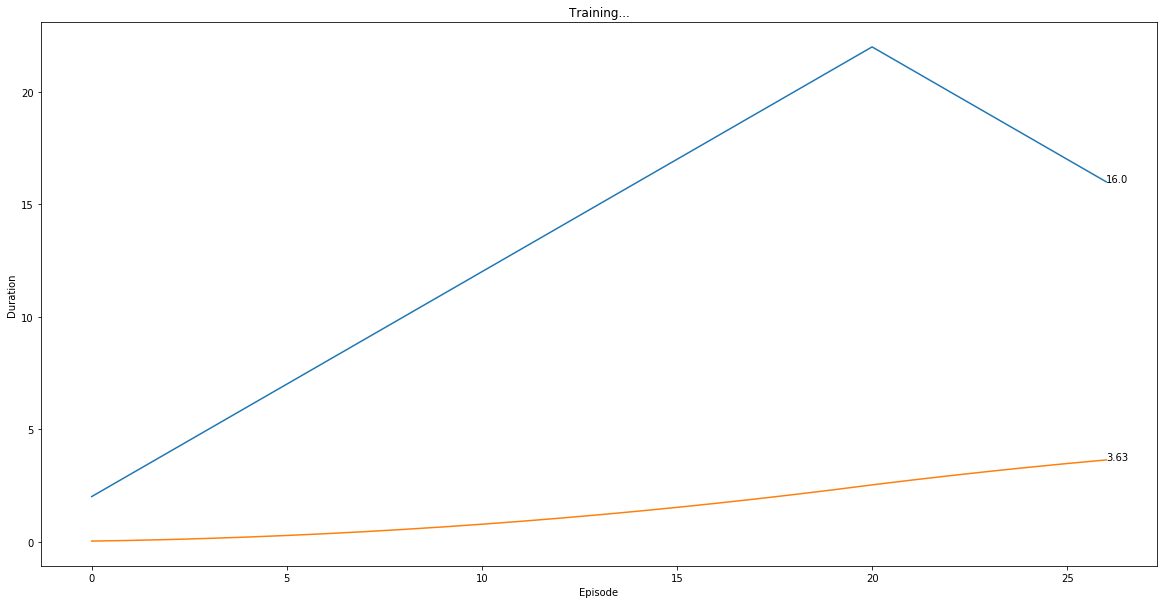

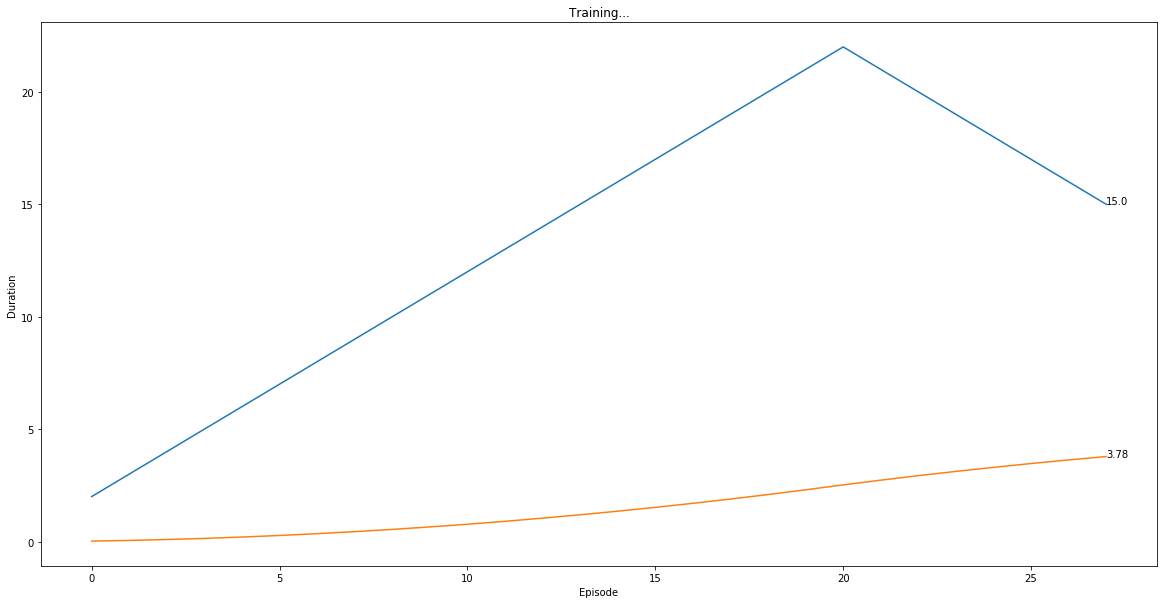

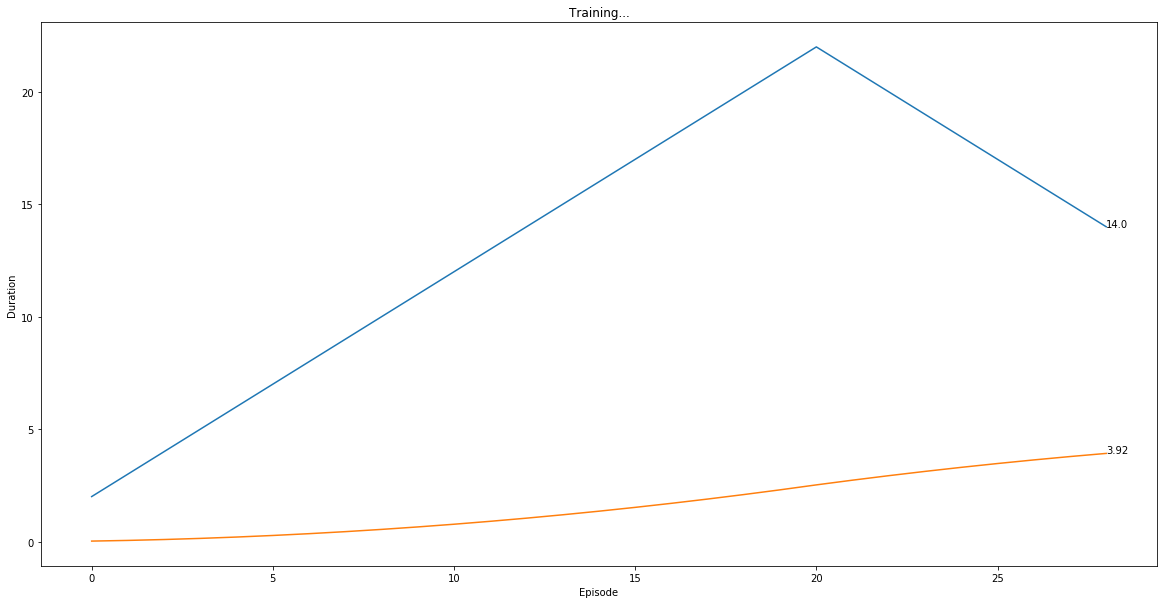

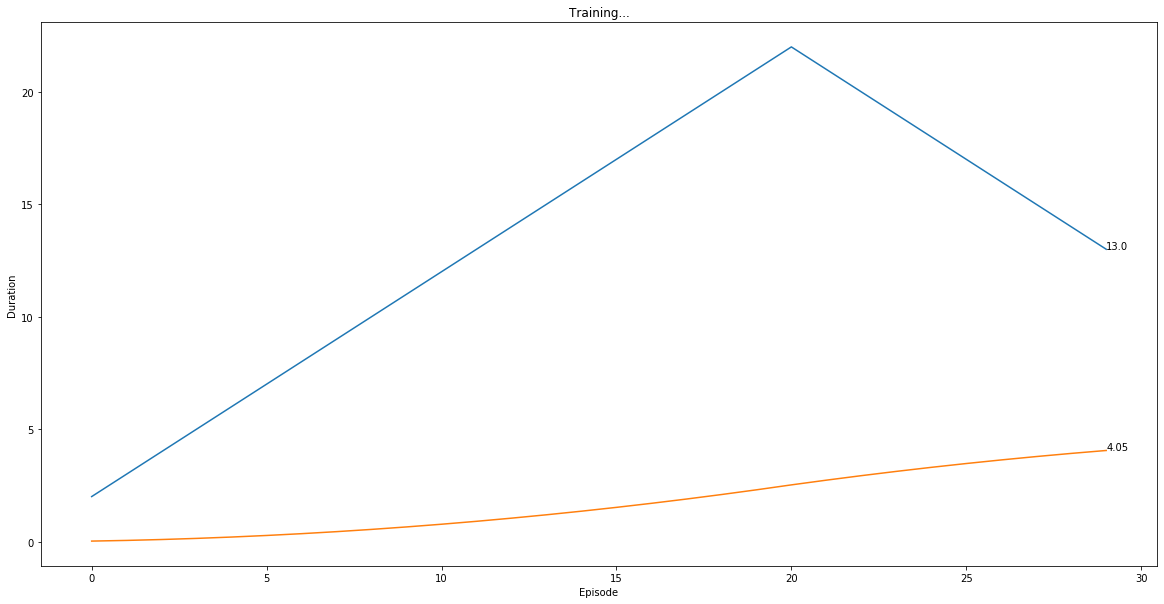

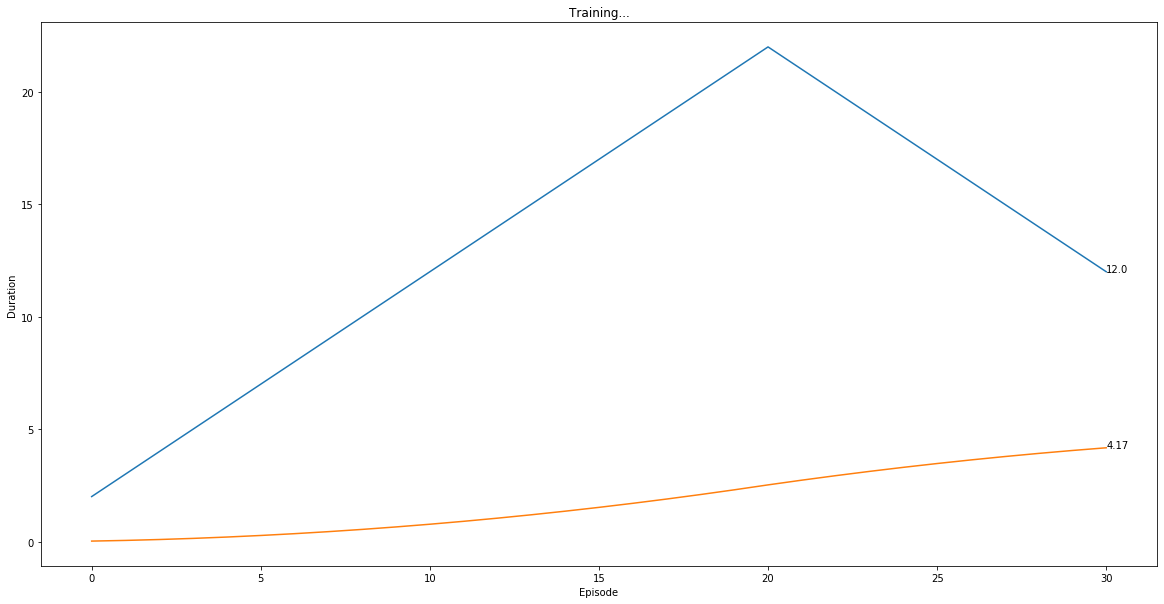

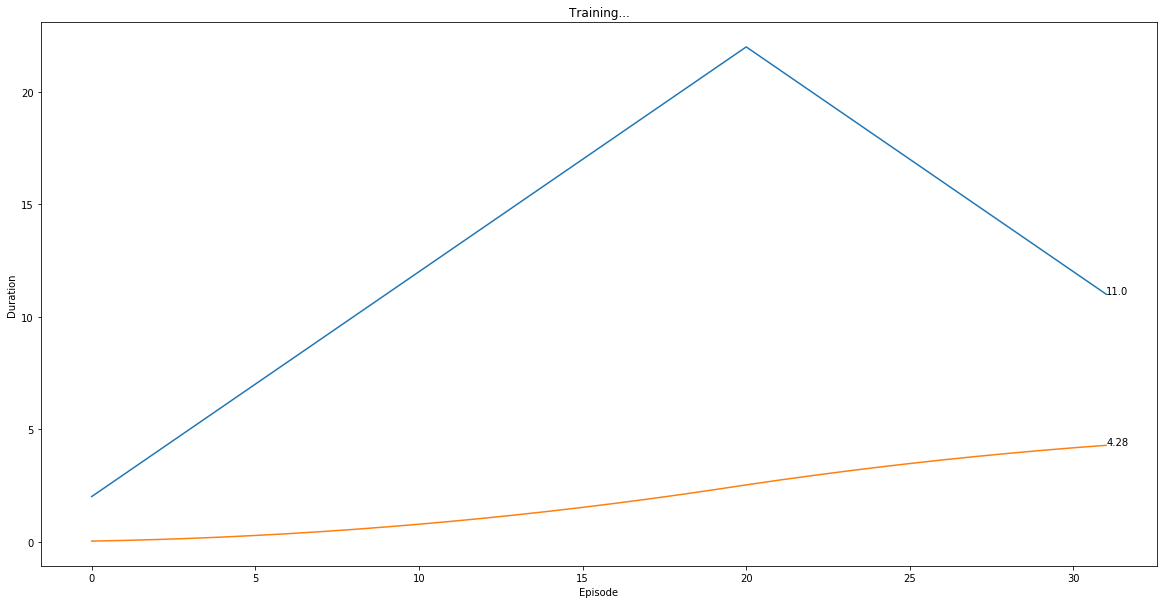

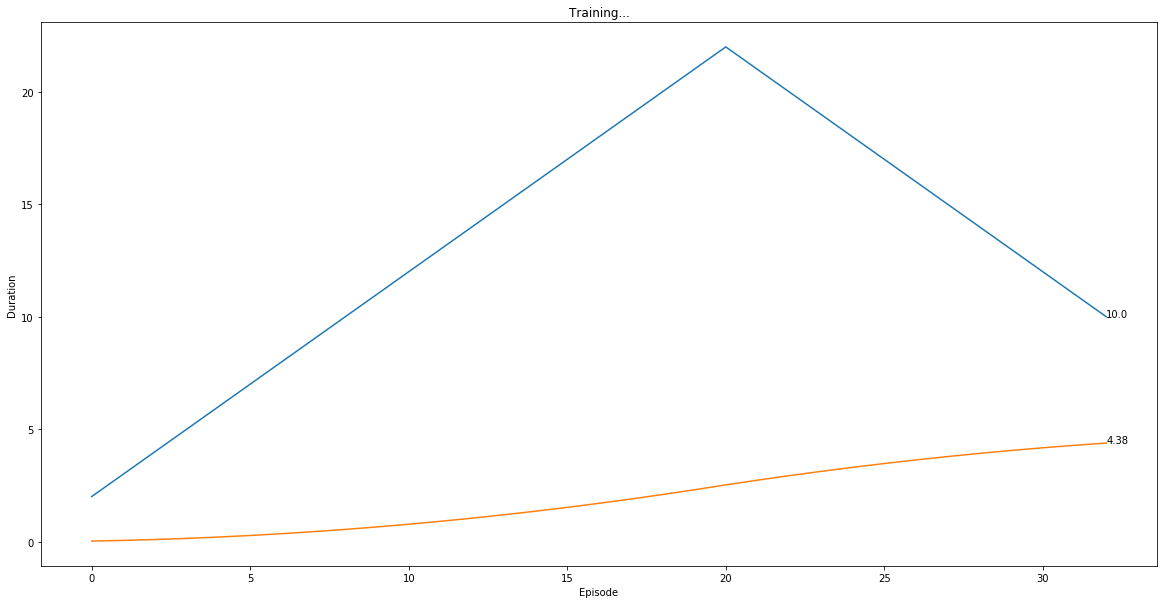

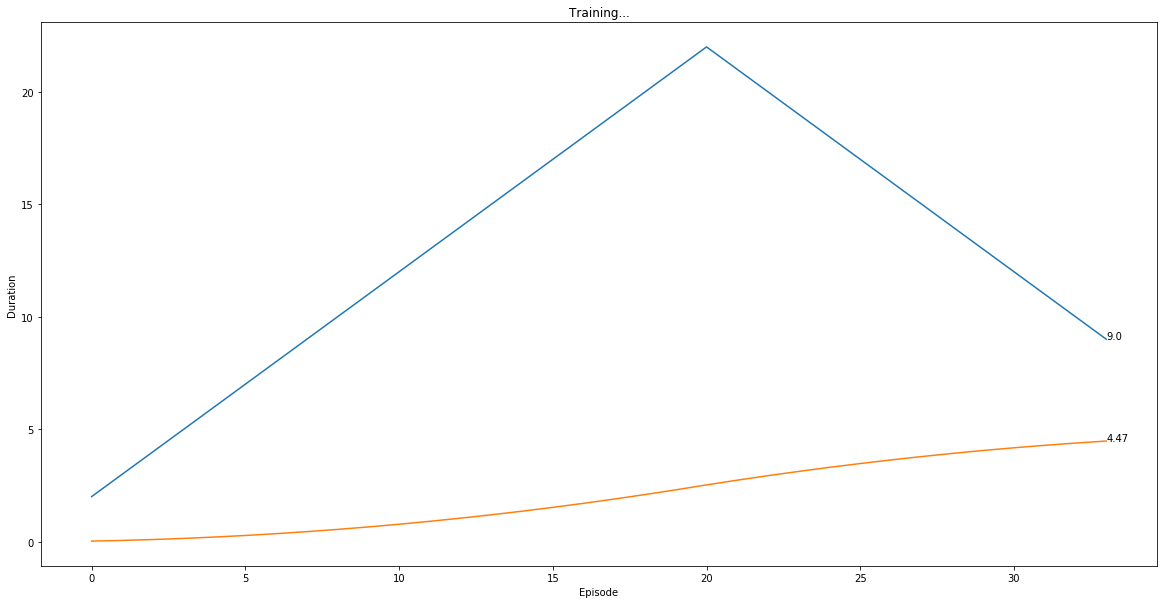

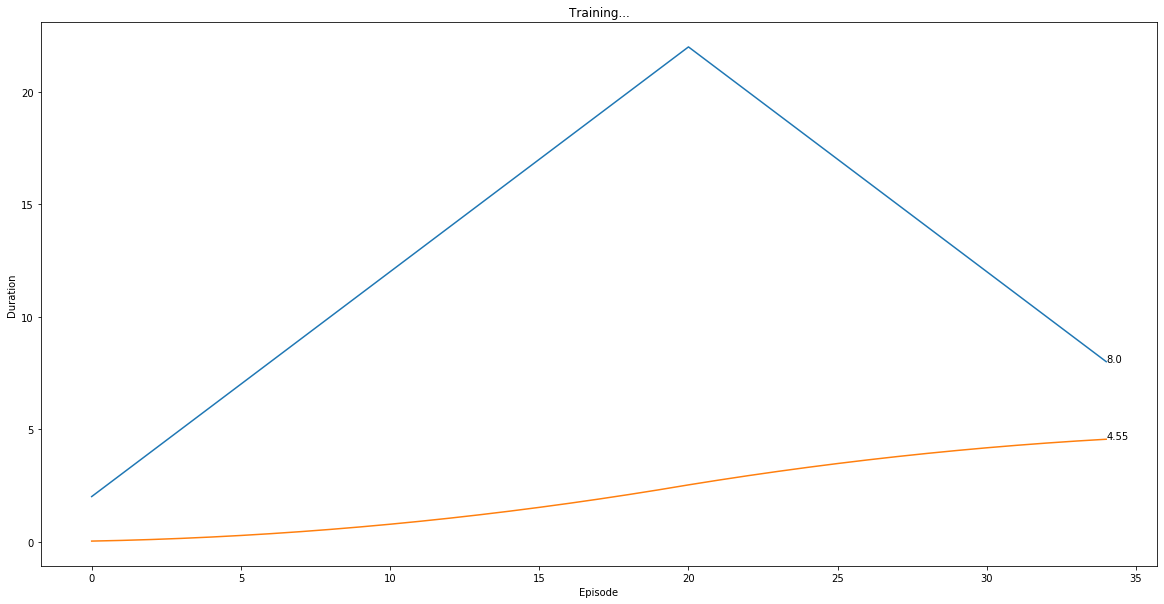

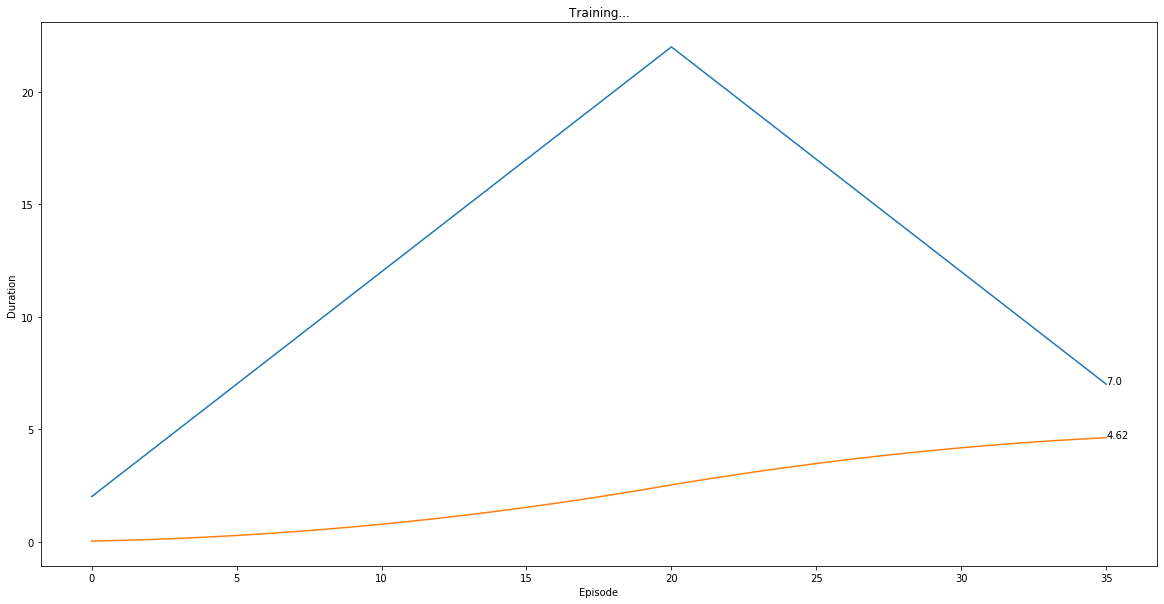

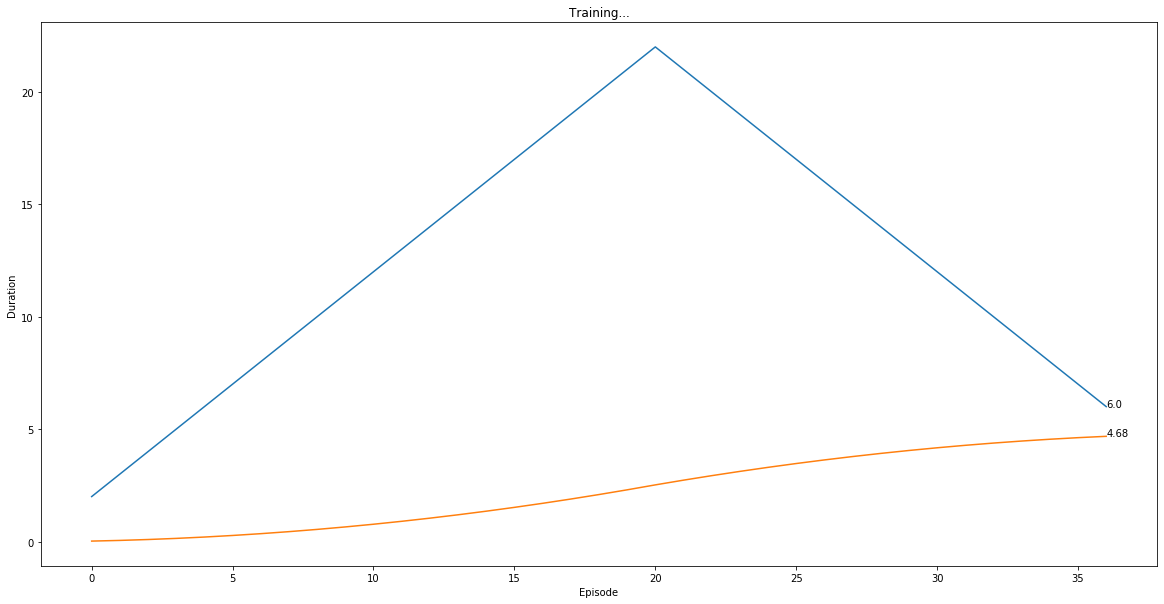

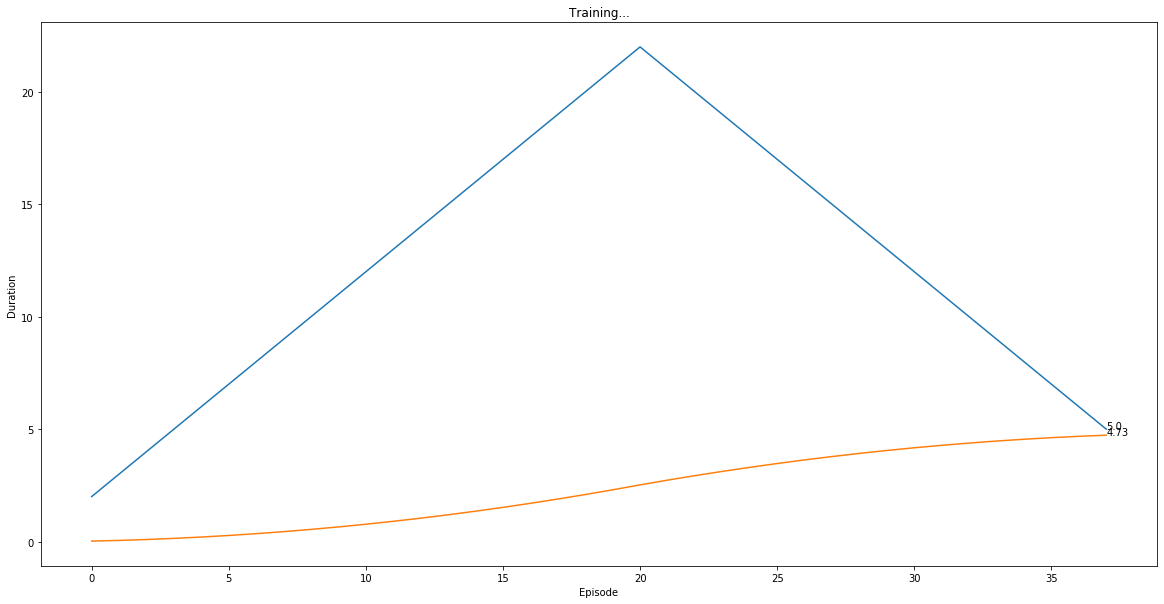

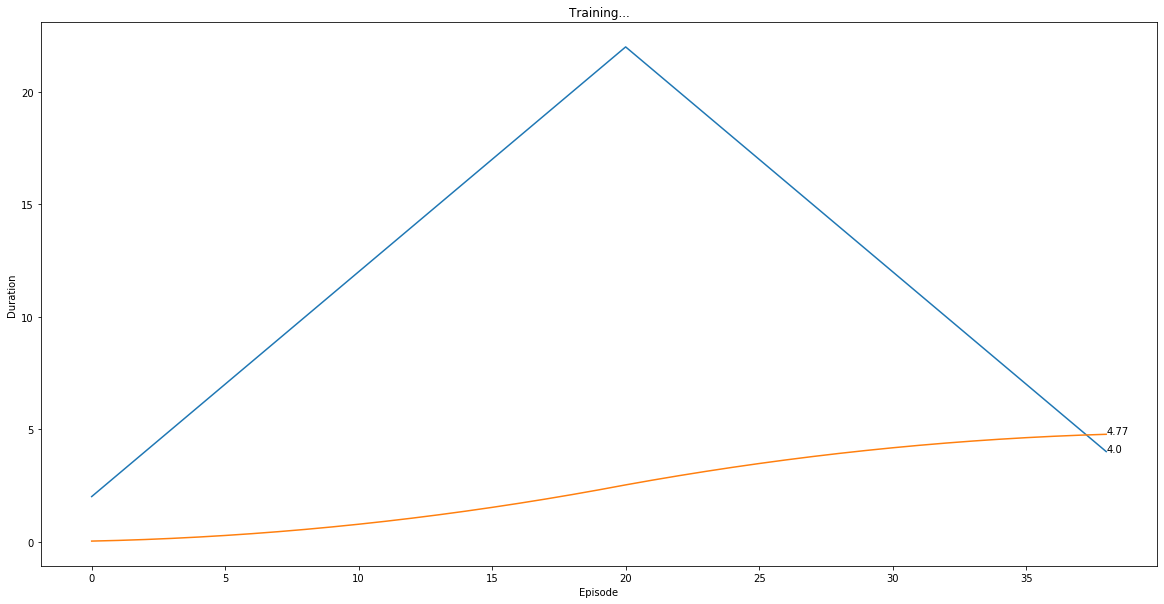

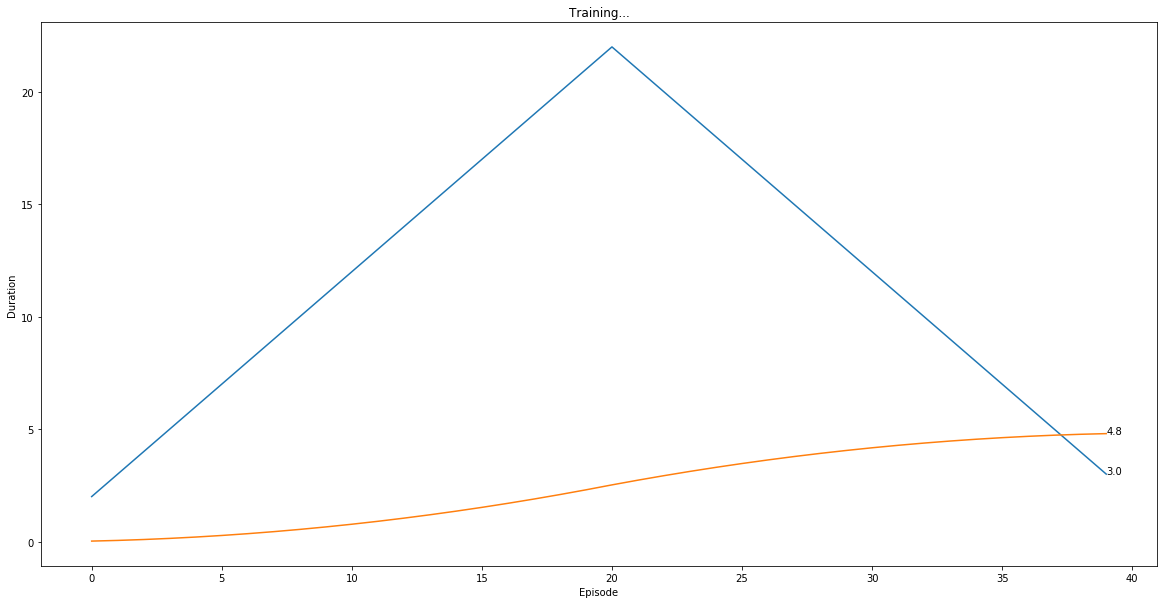

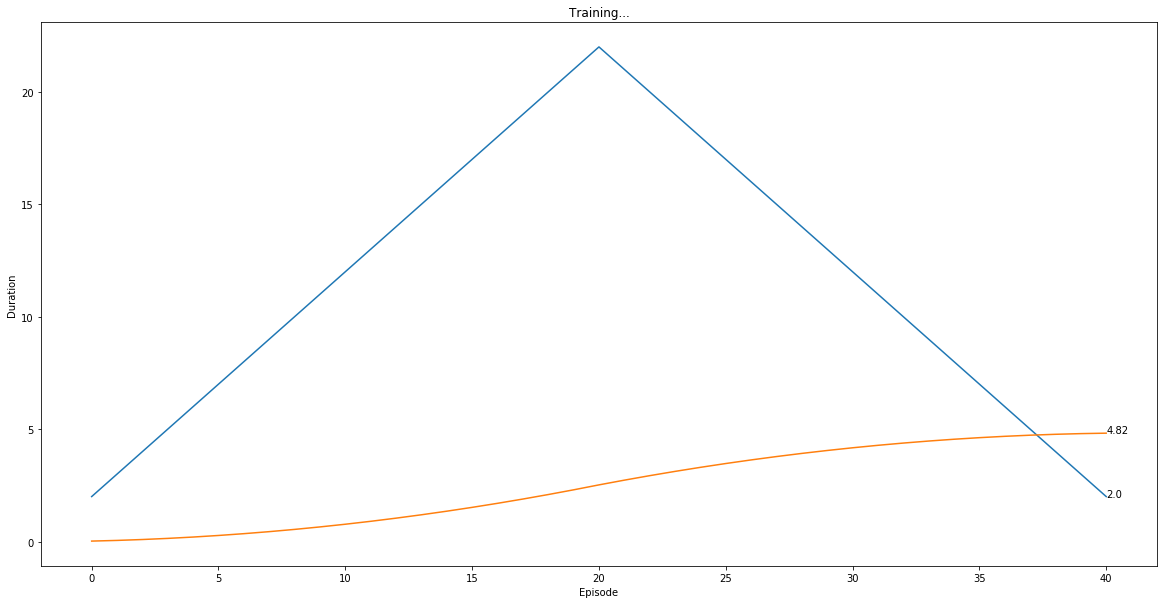

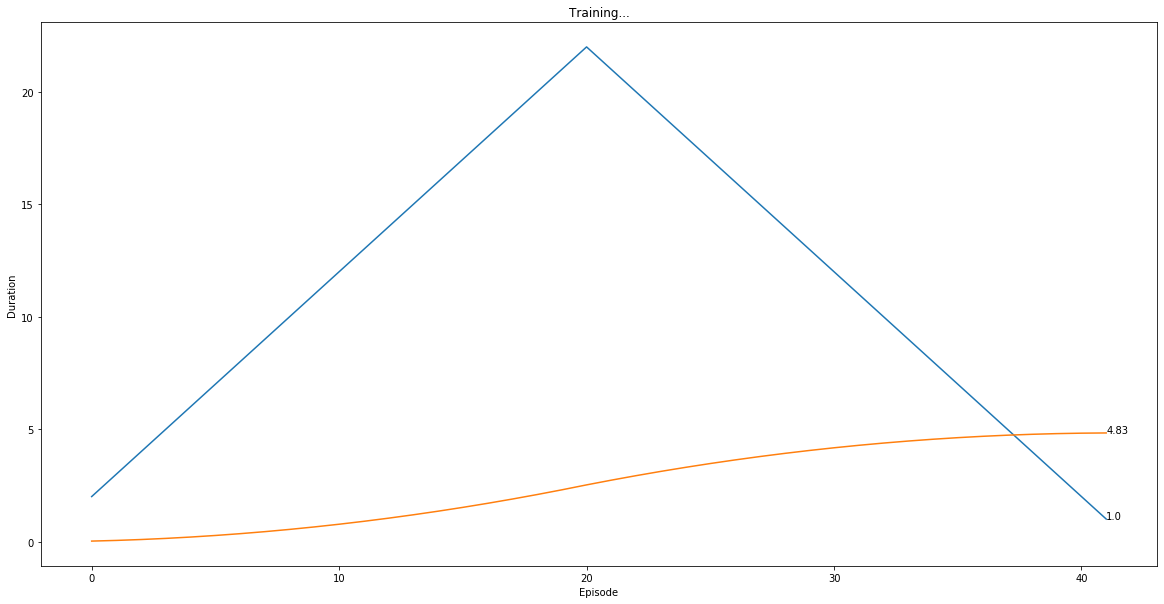

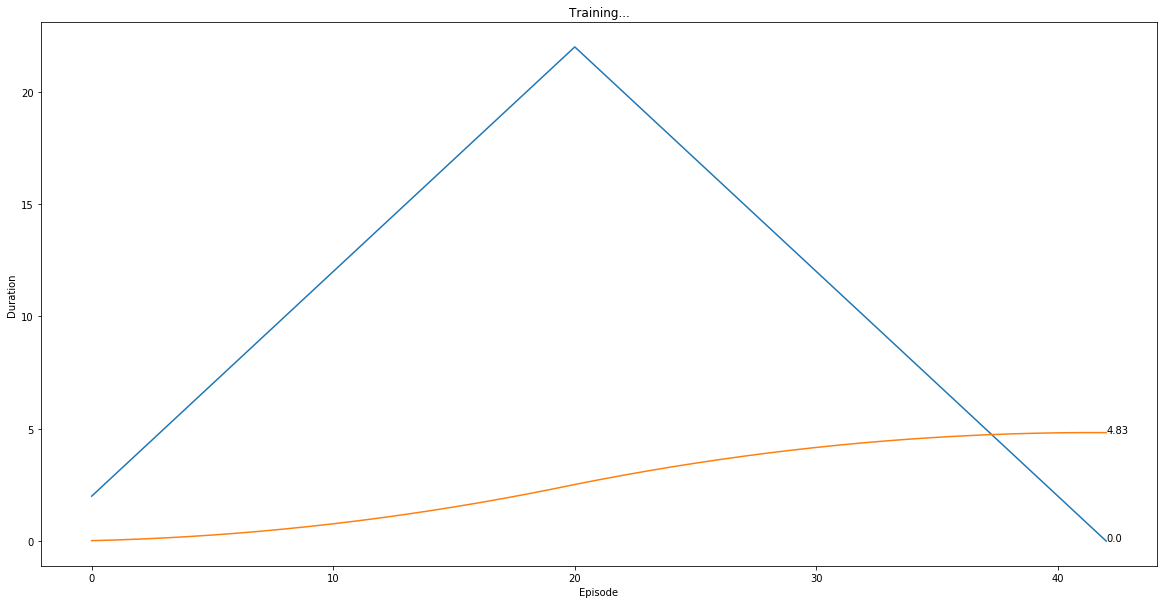

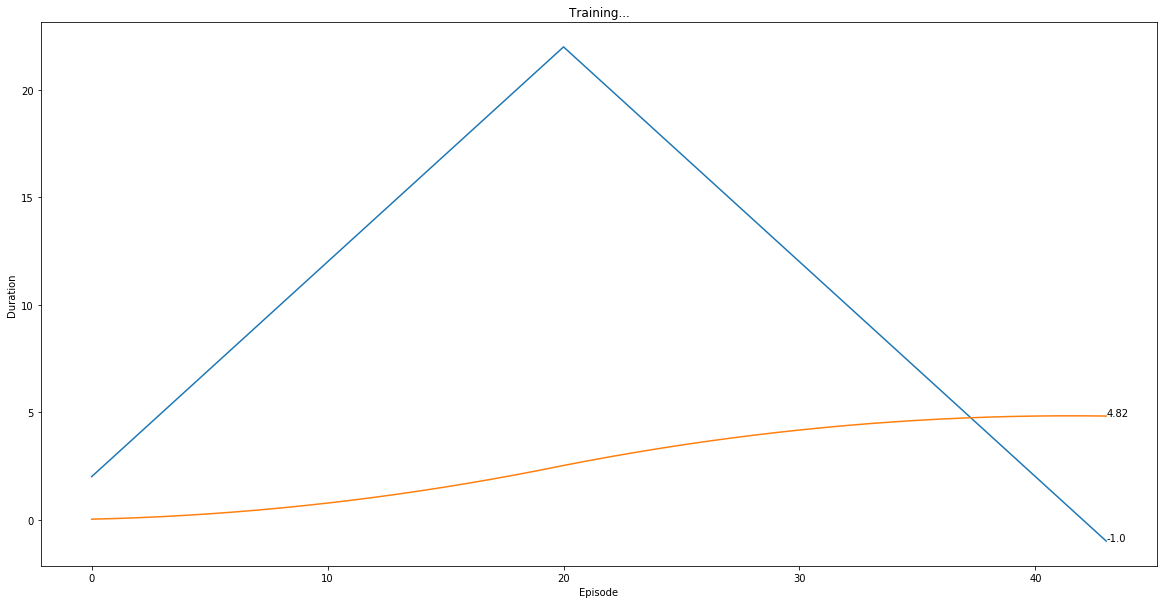

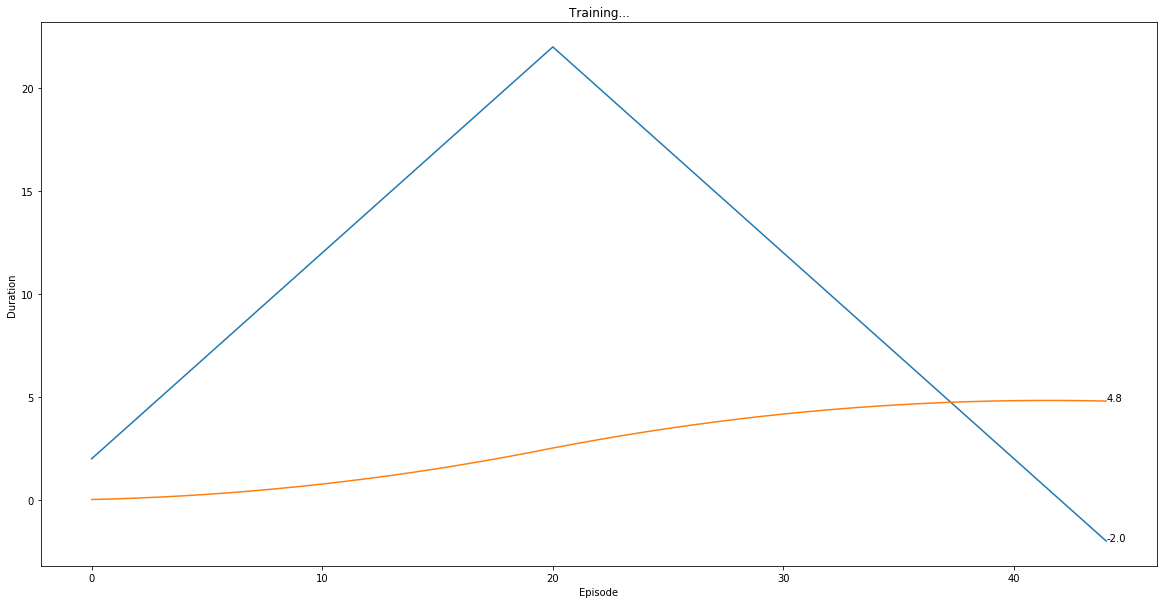

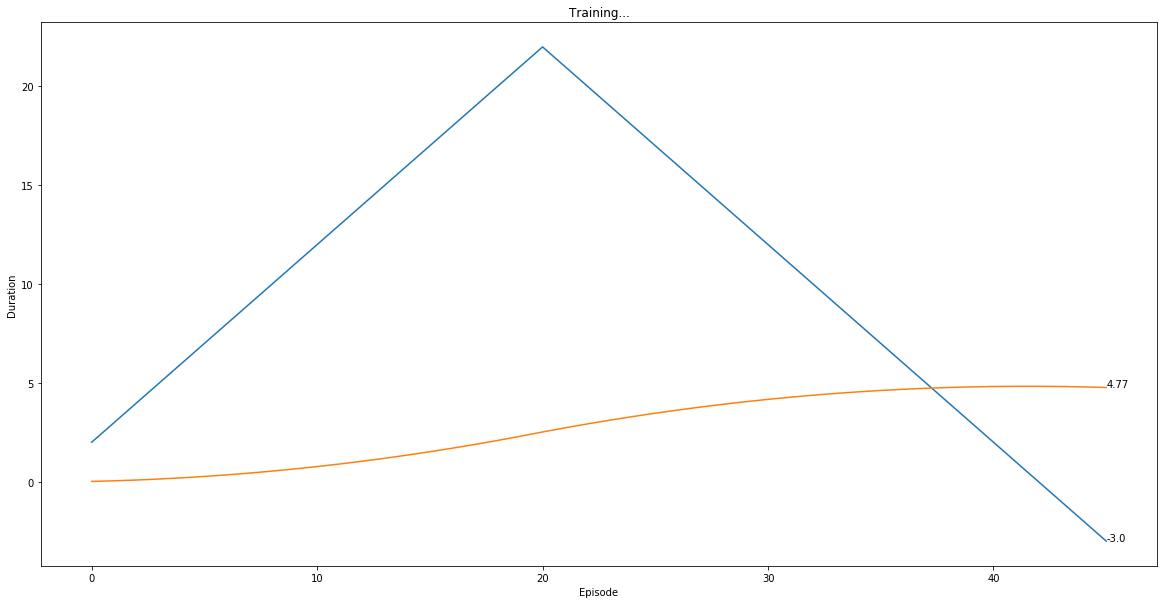

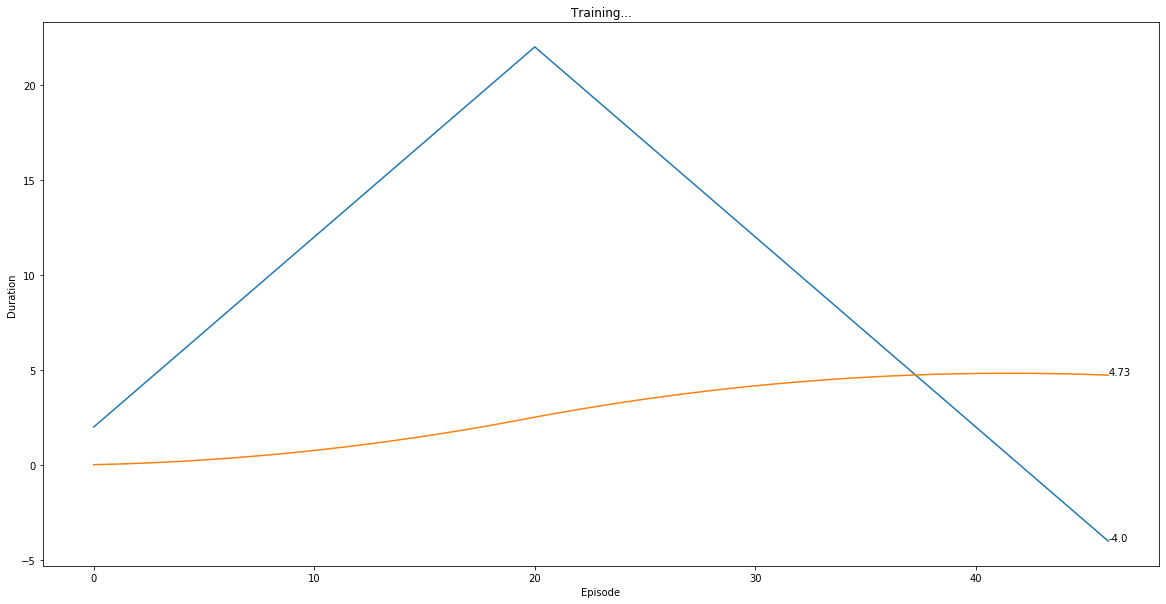

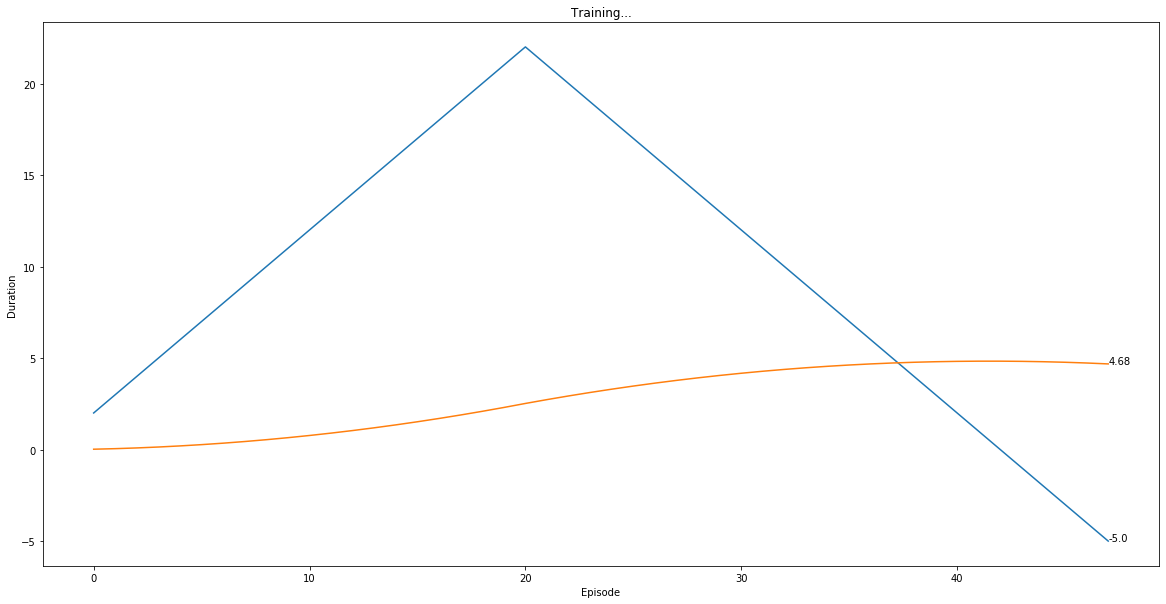

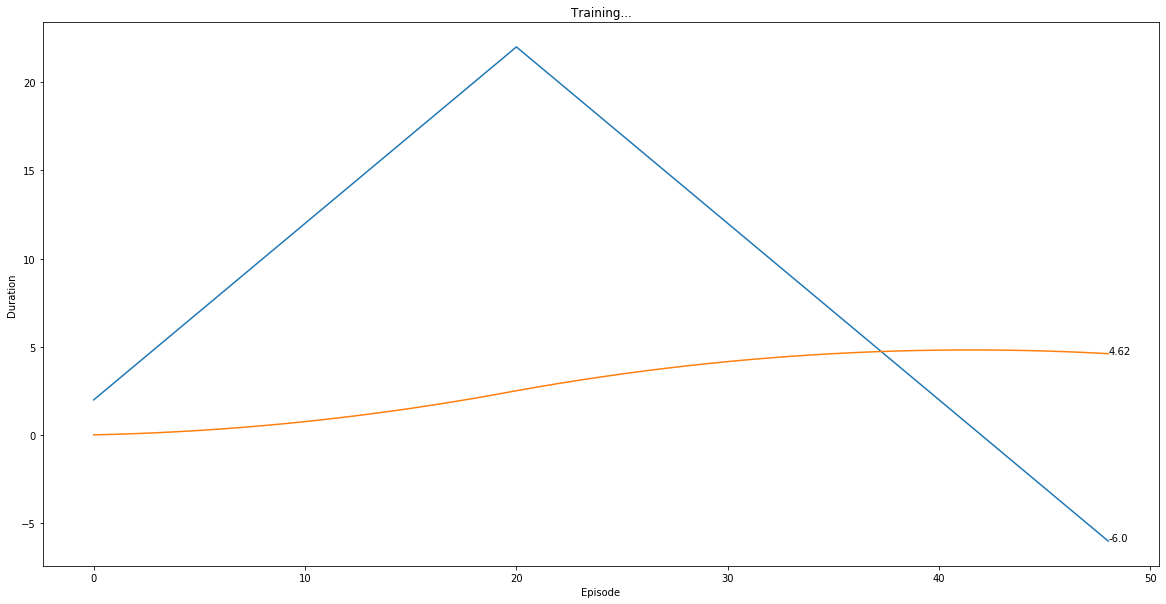

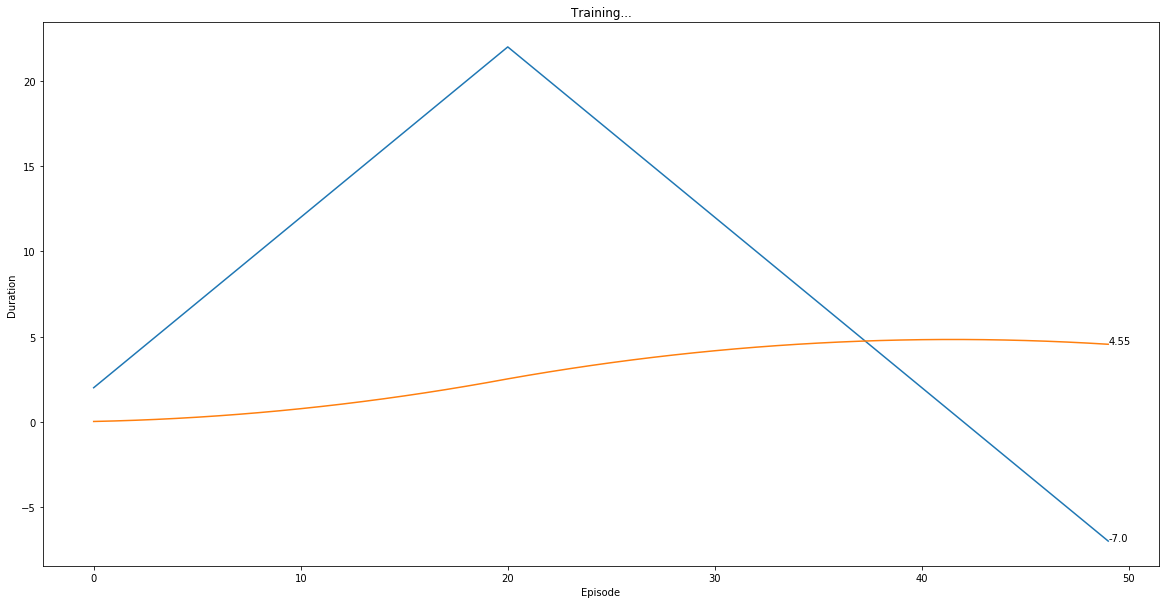

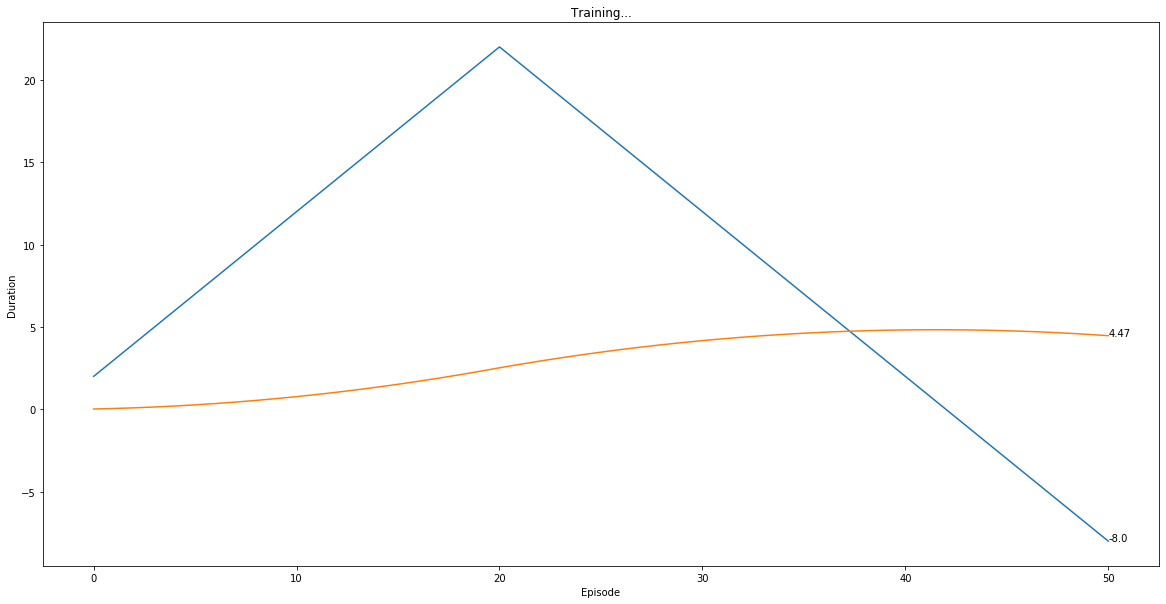

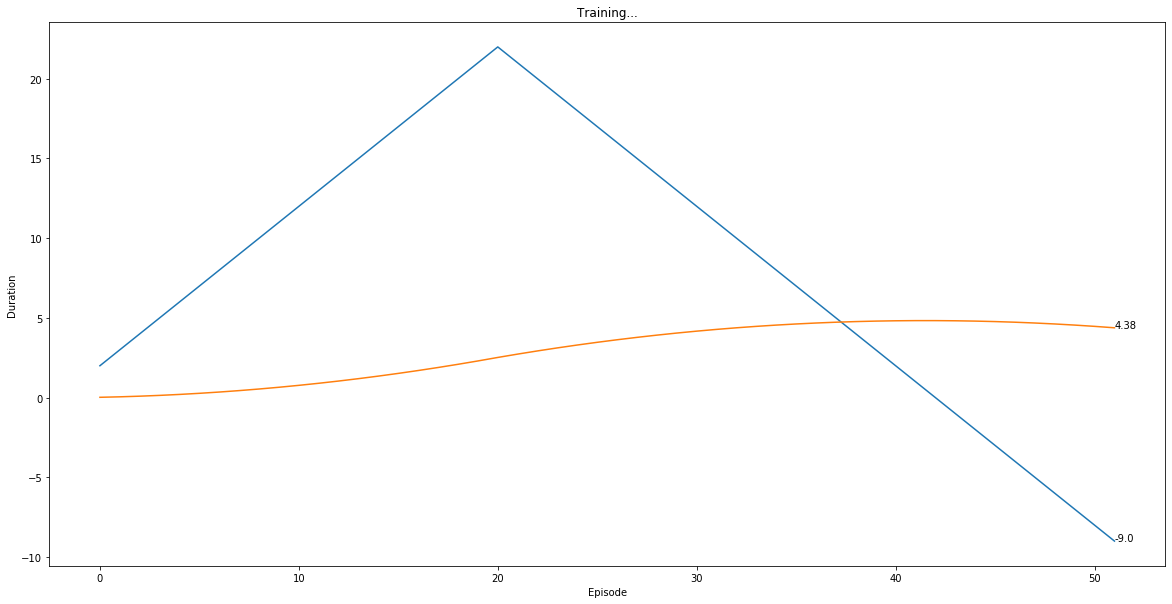

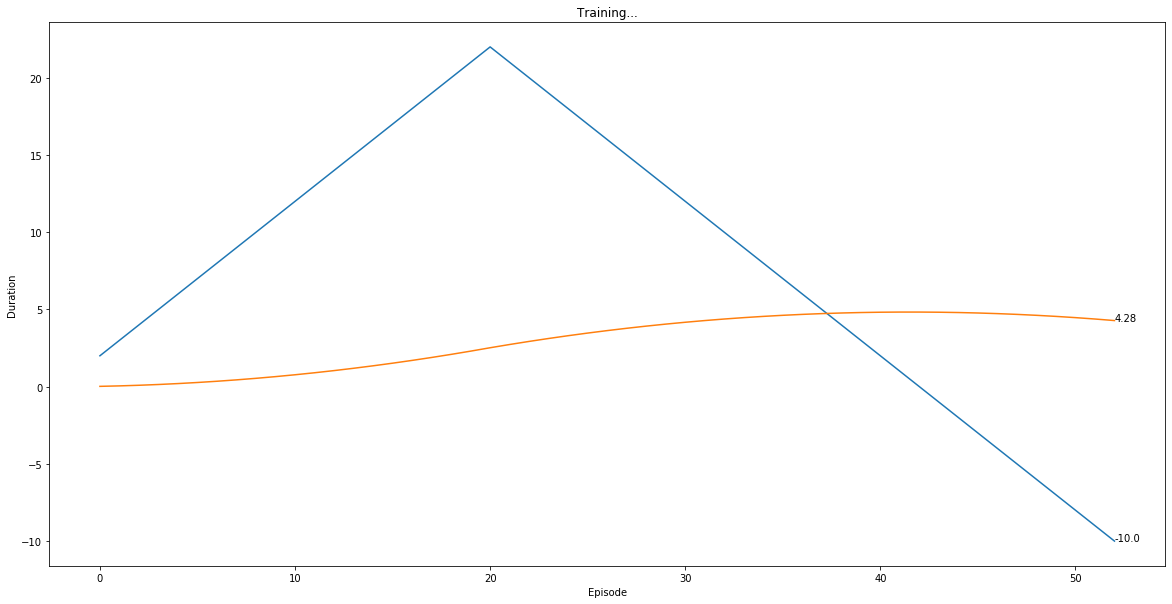

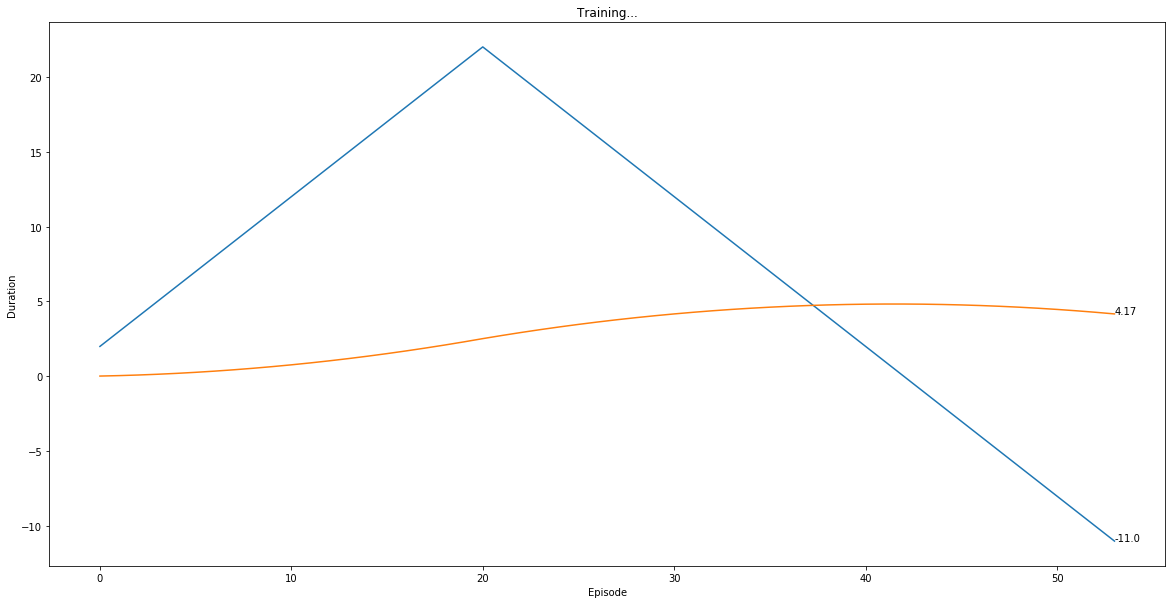

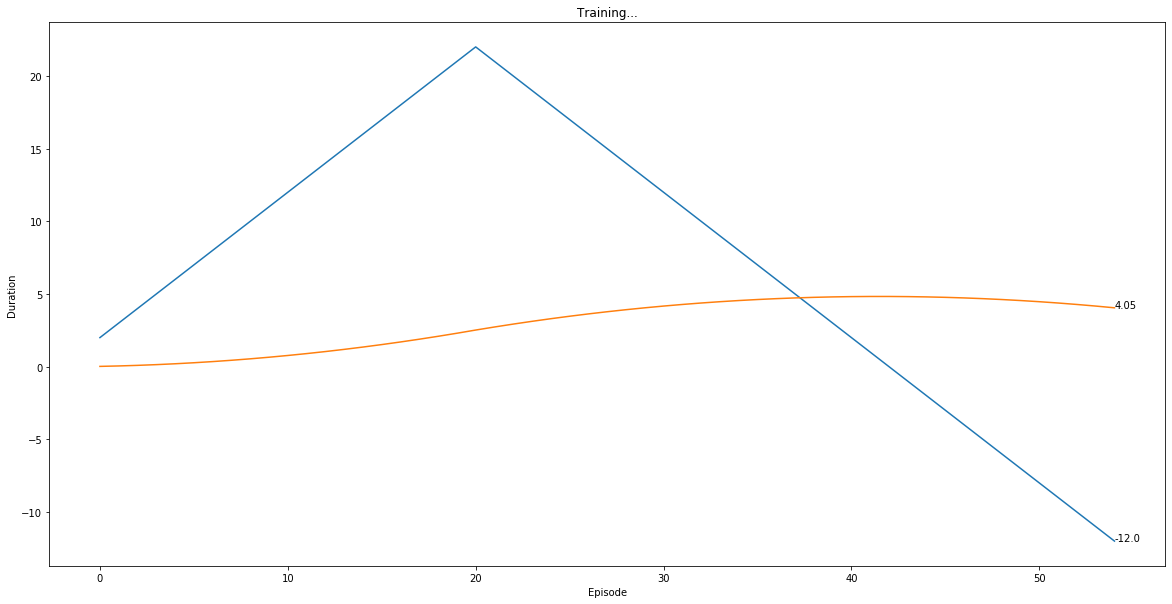

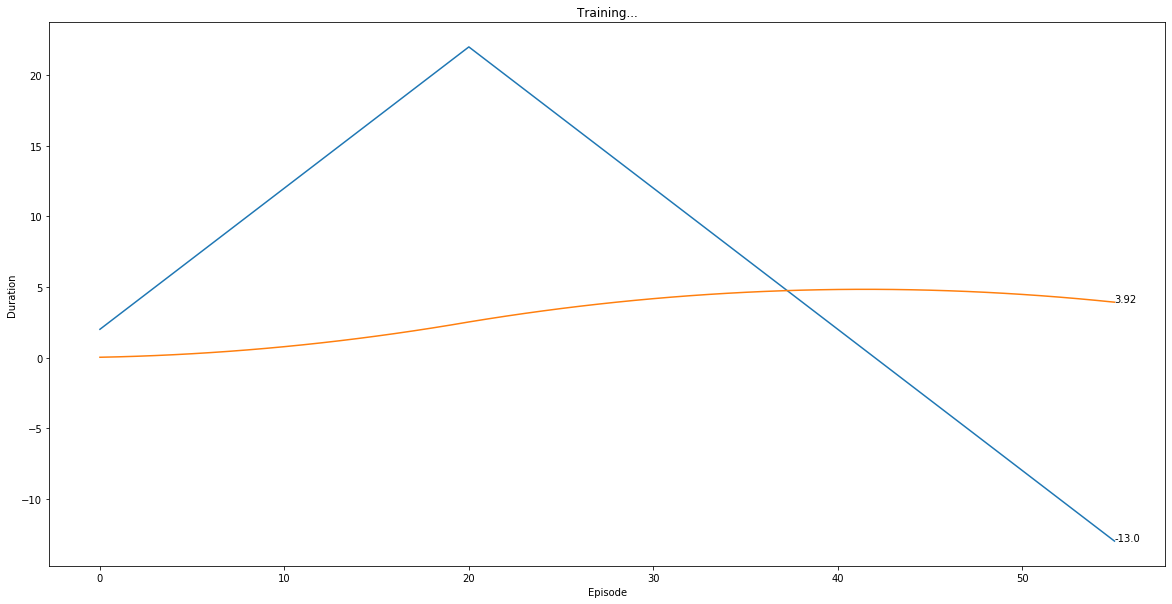

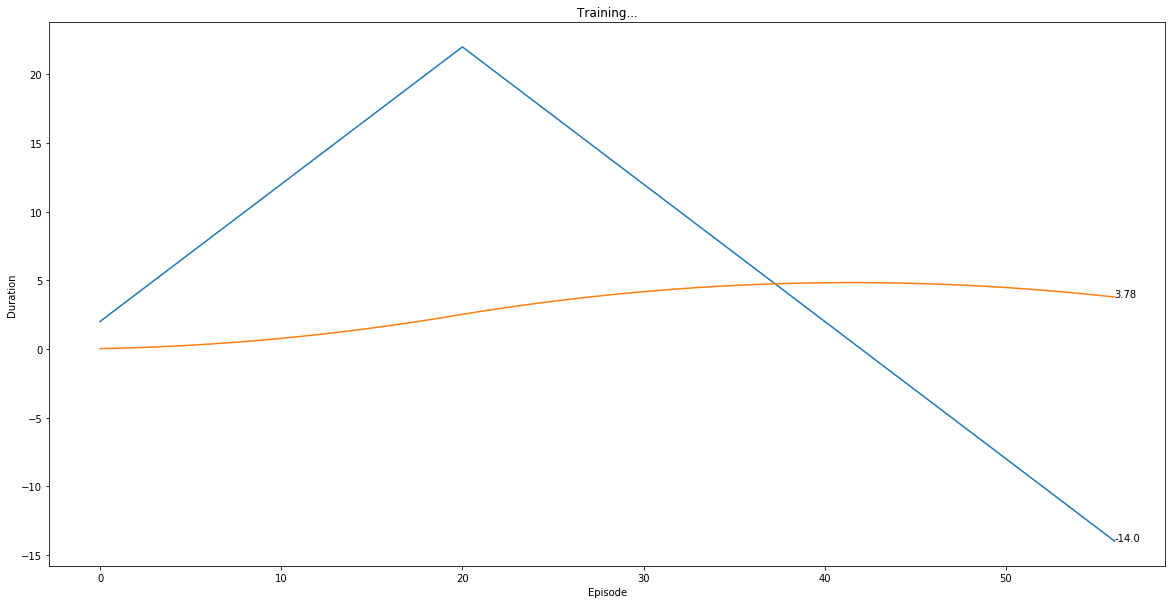

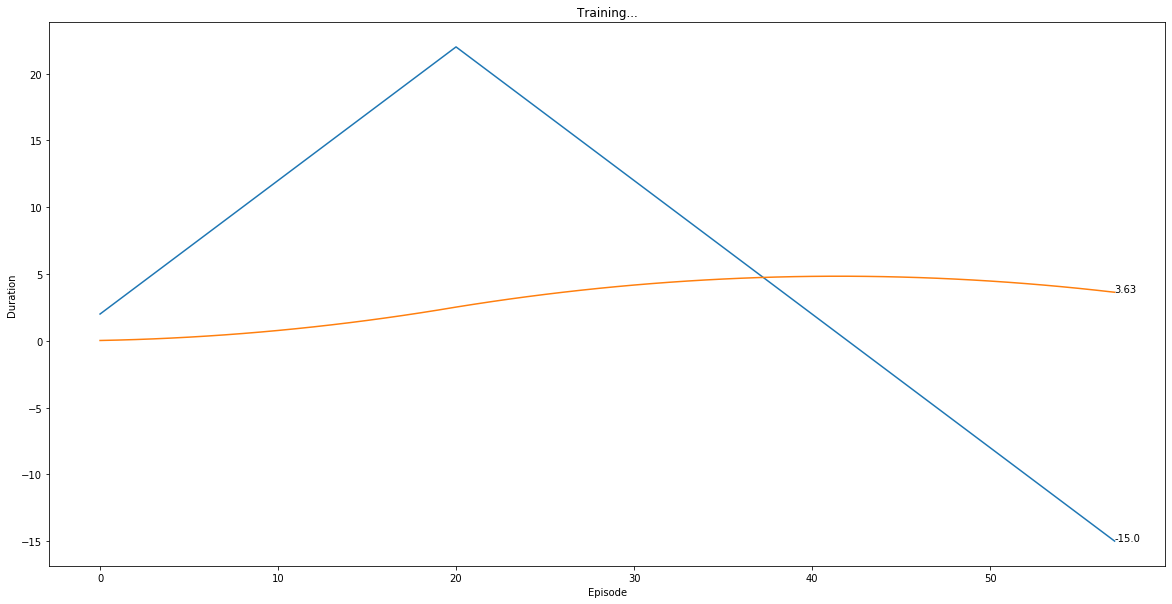

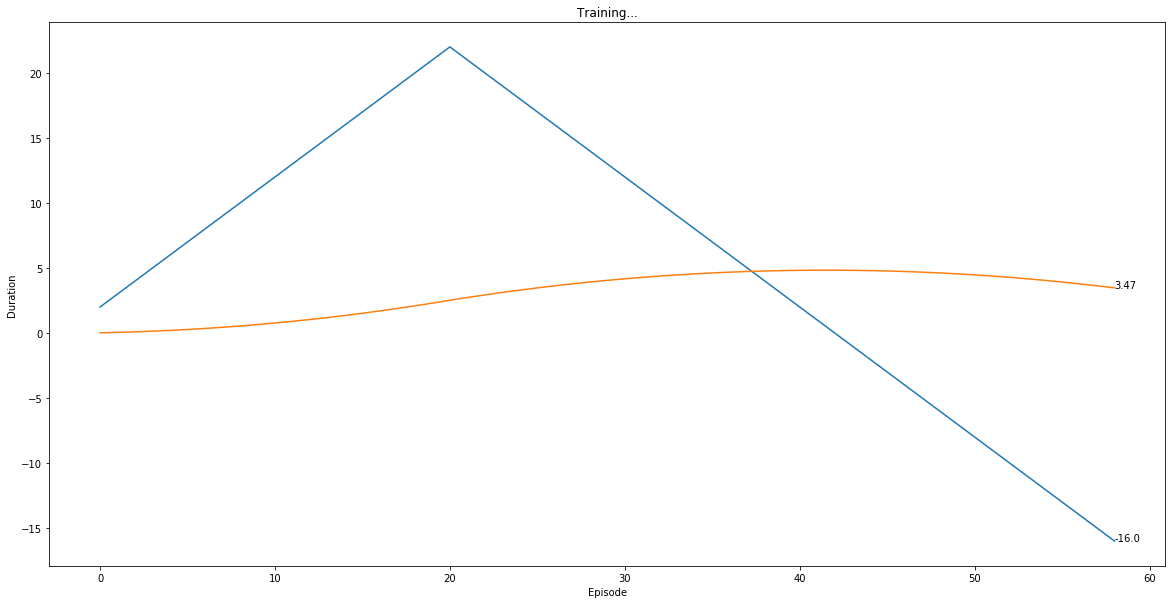

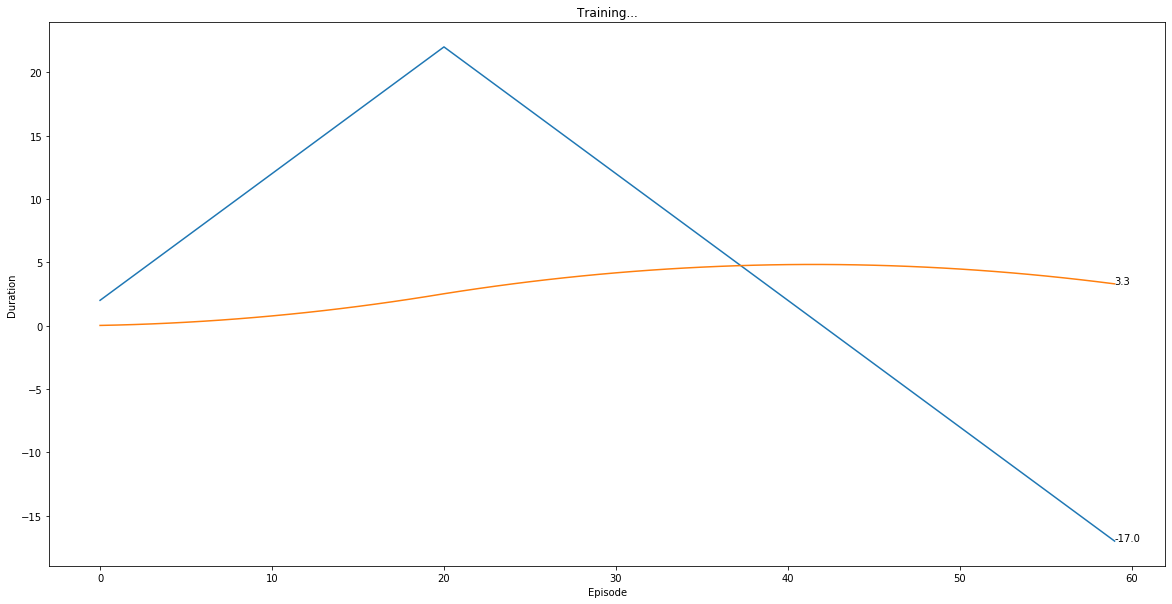

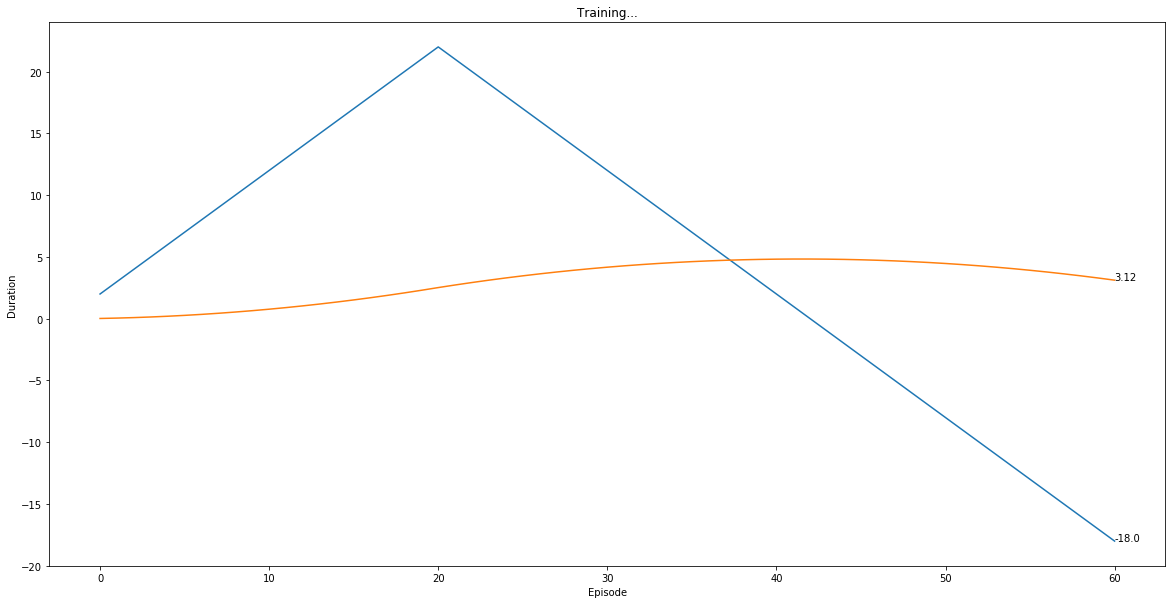

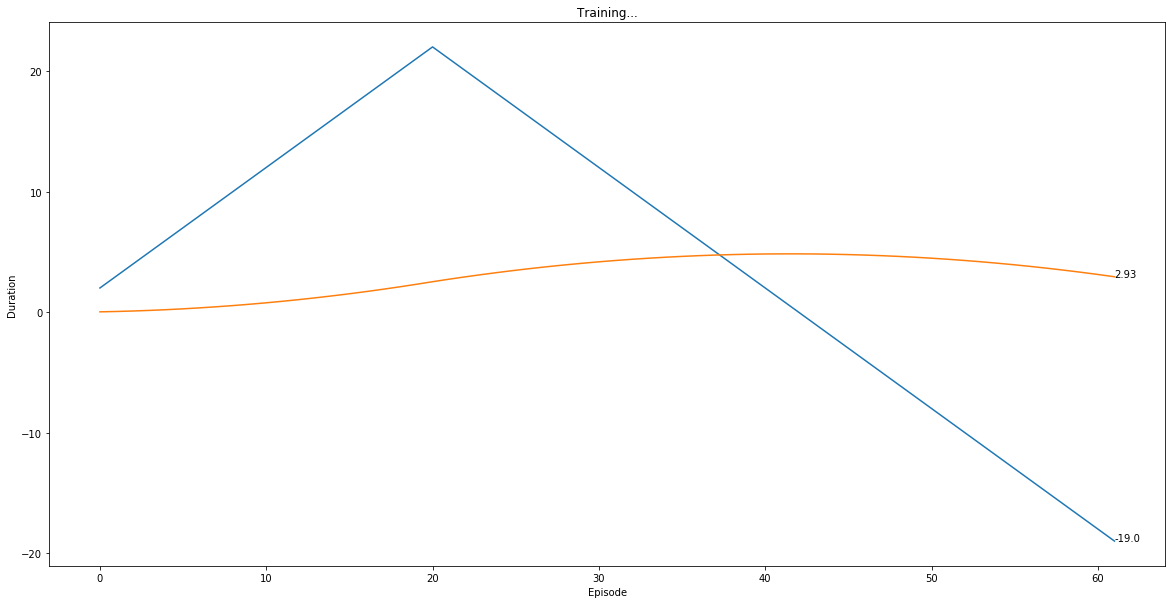

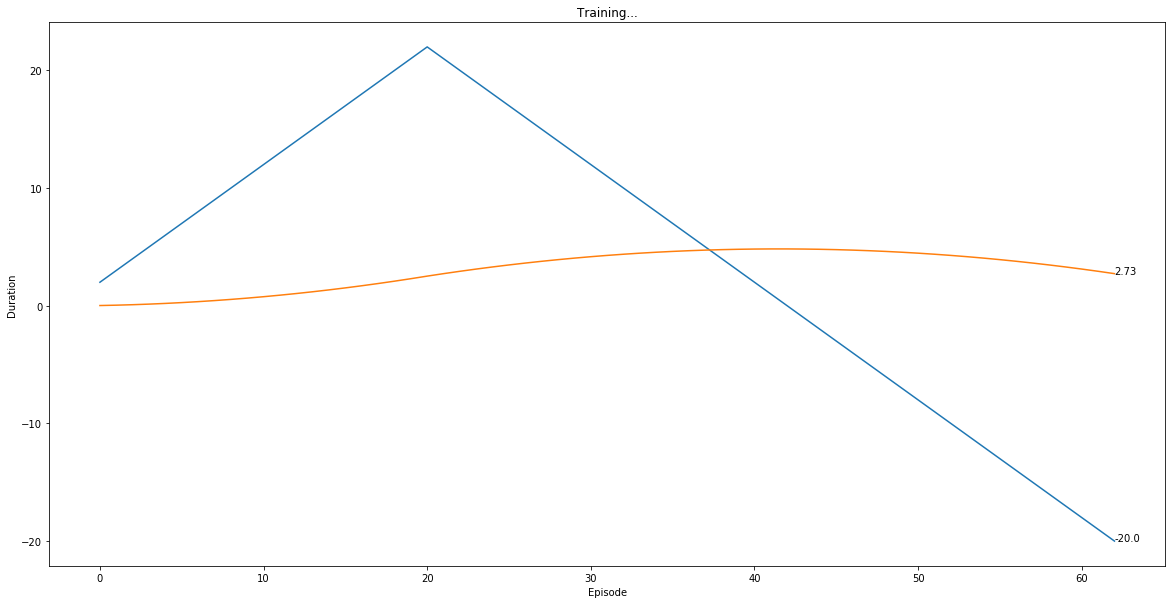

In [28]:
dqn.train()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

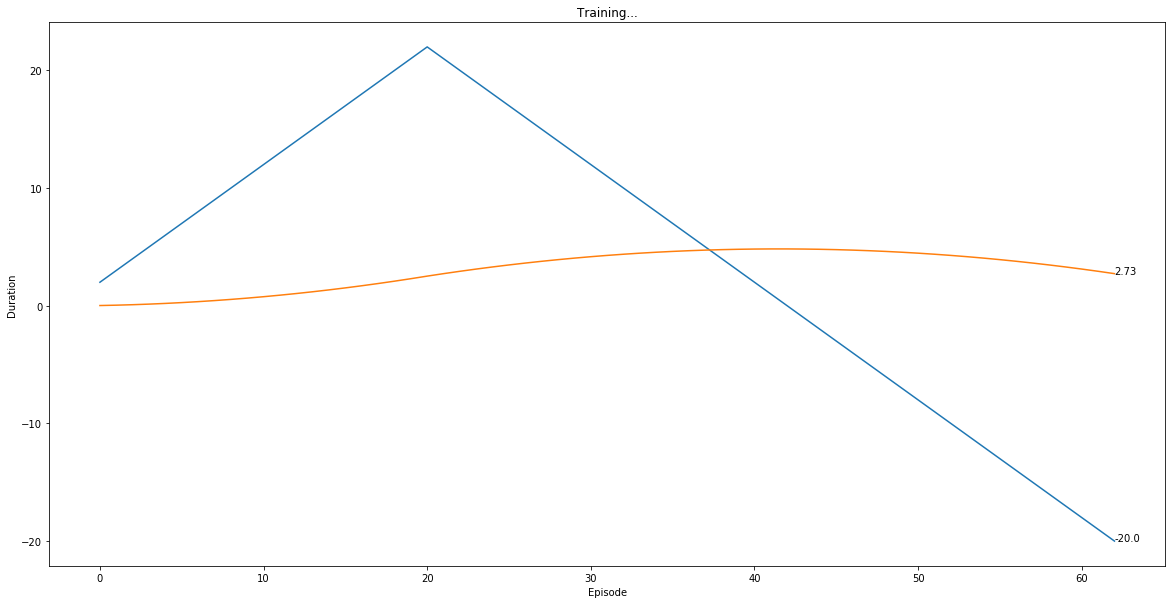

In [29]:
dqn.plot_result()